### Idenfitication of Bay Area Comparable Regions for Regional Housing Needs Determination purposes

In [19]:
import pandas as pd
## grab FRED API data on inflation

pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data, wb
from pandas.api.types import CategoricalDtype
from fiona.crs import from_epsg
import geopandas as gpd

from sklearn.neighbors import KDTree
from sklearn.cluster import DBSCAN
from sklearn import metrics

import os

import requests, json
import urllib2

import pylab as P
#pd.options.display.mpl_style = 'default'

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm, matplotlib.font_manager as fm
sns.set(style="darkgrid")
%pylab inline

pd.set_option('display.max_columns', 1800)
pd.set_option('display.width', 1800)

# Get current size
fig_size = plt.rcParams["figure.figsize"]
print "Current size:", fig_size
 
# Set figure width to 12 and height to 9
fig_size[0] = 9
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
print "Current size:", fig_size
plt.rcParams['figure.figsize']
plt.style.use('ggplot')

from pandas.api.types import CategoricalDtype

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rc('pdf', fonttype=42)
box=os.getenv('BOX_LOC')
drop=os.getenv('DROPBOX_LOC')



Populating the interactive namespace from numpy and matplotlib
Current size: [6.0, 4.0]
Current size: [9, 6]


/Users/aolsen/anaconda2/envs/geoenv/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['box', 'colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [35]:
pct=lambda x: x/x.sum()

In [20]:
from shapely.geometry import Point
from geopandas import GeoDataFrame, read_file
from geopandas.tools import overlay
from geopandas.tools import sjoin
import geopandas as gpd
import textwrap

In [21]:
import matplotlib.ticker as ticker
fmt = lambda x,pos: '{:,.0f}'.format(x)
cbar_kws={'format': ticker.FuncFormatter(fmt)}
fmt_float = lambda x,pos: '{:,.3f}'.format(x)
cbar_kws_float={'format': ticker.FuncFormatter(fmt_float)}
import matplotlib.patches as patches

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as colors
import matplotlib.patheffects as PathEffects

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

### Load and prepare mappings

In [22]:
## get abag-naics mapping
names=['NAICS','ABAGSector','mtc11','mtc6','EDDSector','ACS']
naics_mappings = pd.read_excel(os.path.join(drop, 'Documents/Data/BayArea/Projections 2013/NAICS_to_ABAG_SECTORS.xlsx'),sheetname='both')
naics_mappings.head(2)

,NAICS-2,ABAG-6,ABAG-11,MTCname,eddname,acs,ind_census
0,11,Agriculture & Natural Resources,Agriculture & Natural Resources,agrempn,Agriculture and Natural Resources,"Agriculture, forestry, fishing and hunting, an...",ind_other
1,21,Agriculture & Natural Resources,Agriculture & Natural Resources,agrempn,Agriculture and Natural Resources,"Agriculture, forestry, fishing and hunting, an...",ind_other


In [23]:
## SOC codes
soc = pd.read_csv(os.path.join(drop, 'Documents/Data/_BLS/SOC/soc_structure_2010_major.csv'))
soc['soc_2']=soc['Major Group'].apply(lambda x: (x[:2]))
soc.head(3)

socmap=soc.set_index(['soc_2']).Description#shortname

#### Geographical mappings
Relate PUMAs to more meaningful geographies

In [95]:
bayareafips_full ={'06001':'Alameda', '06013':'Contra Costa', '06041':'Marin', '06055':'Napa', '06075':'San Francisco', '06081':'San Mateo', '06085':'Santa Clara', '06097':'Sonoma', '06095':'Solano'}

## for regex use to grab bay area counties
cntystr='({})'.format('|'.join(bayareafips_full.values()))
cntystr

'(Marin|Contra Costa|Solano|Alameda|Napa|Santa Clara|San Francisco|San Mateo|Sonoma)'

In [25]:
## load an intersect file of PUMAs with FMR areas.
## This will allow us to push FMR areas back to PUMS.

fmrareas_x_puma = gpd.read_file(os.path.join(drop,'Documents/Data/_HUD/FMR/FMR_x_PUMA2015.shp'))
fmrareas_x_puma['STPUMA']=fmrareas_x_puma.STATEFP10+fmrareas_x_puma.PUMACE10
fmrareas_x_puma.crs= from_epsg(4269)

stpuma_x_fmr=fmrareas_x_puma.set_index(['STPUMA','FMR_CODE','FMR_AREANA']).groupby(level=['STPUMA']).Shape_Area.nlargest(1).reset_index(0,drop=True)

stpuma_x_fmrcode = stpuma_x_fmr.reset_index(['FMR_CODE','FMR_AREANA']).FMR_CODE.to_dict()
stpuma_x_fmrarea = stpuma_x_fmr.reset_index(['FMR_CODE','FMR_AREANA']).FMR_AREANA.to_dict()

In [96]:
# ## From HCD, Bay Area MSA-level income limits
# # NOT IN USE SINCE WE USE NATIONAL HUD ONES

# hcd_income_limits=pd.read_excel(os.path.join(drop,'Documents/Data/_HCD/income_limits/2018/inc2k18.xlsx'),'formated')

# hcd_income_limits['County']=hcd_income_limits.County.str.extract(cntystr,expand=False).fillna(method='pad')
# hcd_income_limits=hcd_income_limits.drop(hcd_income_limits.filter(regex='Unn').columns,axis=1)

# hcd_income_limits=hcd_income_limits[hcd_income_limits['Income Category']!='Median Income']
# hcd_income_limits['Income Category']=hcd_income_limits['Income Category'].astype(pd.CategoricalDtype(categories=['Extremely Low','Very Low Income','Low Income','Moderate Income','Above Moderate Income'],ordered=True))
# hcd_income_limits.head()

In [27]:
## get abag-naics mapping

names=['NAICS','ABAGSector','ABAGSector-11','MTCSector','EDDSector','ACS','census']
naics_mappings = pd.read_excel(os.path.join(drop, 'Documents/Data/BayArea/Projections 2013/NAICS_to_ABAG_SECTORS.xlsx'),sheetname='both')
naics_mappings.columns=names
naics_mappings['NAICS']=naics_mappings['NAICS'].astype(str)

#naics_abag = pd.read_csv(os.path.join(drop, r'Documents\Data\BayArea\Projections 2013\NAICS_to_ABAG_SECTORS.csv'),sep='\t',dtype=object)

naics_abag = naics_mappings.set_index('NAICS').ABAGSector.to_dict()
naics_mtc = naics_mappings.set_index('NAICS').MTCSector.to_dict()
naics_abag_11 = naics_mappings.set_index('NAICS')['ABAGSector-11'].to_dict()
naics_acs = naics_mappings.set_index('NAICS').ACS

wrap20=textwrap.TextWrapper(width=40)
naics_acs_wrap=naics_mappings.set_index('NAICS').ACS.apply(lambda x: '\n'.join(wrap20.wrap(text=x)))

In [28]:
# stemdefs=pd.read_excel(os.path.join(drop,'Documents/Data/_BLS/STEM_occupations_OES/stem_2017.xlsx'),'STEM occupations list',skiprows=1)
# stemdefs['OCC_CODE']=stemdefs['OCC_CODE'].str.replace('-','')
# stemdefs['SOCP_3']=stemdefs['OCC_CODE'].str.slice(0,3).map(lambda x: '{:0<6}'.format(x))

# stemdefs=stemdefs.set_index(['OCC_CODE']).OCC_TITLE
# stemdefs.head()

In [29]:
## load OMB MSA definitions

ombdata=pd.read_excel('/Users/aolsen/Dropbox/Documents/Data/_Census/geo/list1_Sep_2018.xls',skiprows=2)

ombdata=ombdata[ombdata['FIPS County Code'].notnull()]
ombdata['STCOUNTY']=ombdata['FIPS State Code'].apply(lambda x: '{:0>2}'.format(int(x)))+\
ombdata['FIPS County Code'].apply(lambda x: '{:0>3}'.format(int(x)))
county_x_csa=ombdata.set_index(['STCOUNTY'])['CSA Title'].fillna('Outside CSA')
county_x_cbsa=ombdata.set_index(['STCOUNTY'])['CBSA Title'].fillna('Outside CBSA')

ombdata=ombdata.groupby(['CBSA Code','CSA Code','CSA Title']).size().reset_index(name='count')
ombdata['CSA Code']=ombdata['CSA Code'].apply(lambda x: '{:0>3}'.format(int(x)))

cbsa_x_csa=ombdata.set_index(['CBSA Code'])['CSA Title']
cbsa_x_csa.head()

CBSA Code
10300       Detroit-Warren-Ann Arbor, MI
10420         Cleveland-Akron-Canton, OH
10540    Portland-Vancouver-Salem, OR-WA
10580             Albany-Schenectady, NY
10620           Charlotte-Concord, NC-SC
Name: CSA Title, dtype: object

In [30]:
## load PUMA to MSA correspondence from Missouri Census Data Center
## not in use - we did our own union

# puma_x_msa=pd.read_csv(os.path.join(drop,'Documents/Data/_Census/geo/puma_x_msa_mcdc_geocorr12.csv'),skiprows=1)
# puma_x_msa['STPUMA']=puma_x_msa['FIPS state'].apply(lambda x: '{:0>2}'.format(x))+puma_x_msa['puma12'].apply(lambda x: '{:0>5}'.format(x))
# puma_x_msa=puma_x_msa.groupby(['cbsa','CBSA Name','STPUMA','PUMA12 Name']).size().reset_index(name='value')
# puma_x_msa['CSA']=puma_x_msa.cbsa.map(cbsa_x_csa)
# print(puma_x_msa.shape)
# #puma_x_msa=puma_x_msa[puma_x_msa.CSA.notnull()]
# print(puma_x_msa.shape)
# puma_x_msa['CSA']=puma_x_msa['CSA'].fillna('Outside CBSA')

In [31]:
#puma_x_msa[puma_x_msa.STPUMA=='0605301']

In [32]:
migpumacodes=pd.read_excel('/Users/aolsen/Dropbox/Documents/Data/_Census/ACS/PUMS/2018/ACSPUMS2018CodeLists.xls',sheetname='MIGPUMA-POWPUMA 2018 lookup',
                           skiprows=3,dtype=object,names=['ST','COUNTY','COUNTYNAME','MIGSP','MIGPUMA'])
migpumacodes['STCOUNTY']=migpumacodes.ST+migpumacodes.COUNTY
migpumacodes['MIGSTPUMA']=migpumacodes.MIGSP+migpumacodes.MIGPUMA
migpumacodes=migpumacodes[migpumacodes.MIGSTPUMA.notnull()]
migpumacodes['CSA']=migpumacodes.STCOUNTY.map(county_x_csa).fillna('Outside CSA')
migpumacodes['CBSA']=migpumacodes.STCOUNTY.map(county_x_cbsa).fillna('Outside CBSA')
migpumacodes.head()

,ST,COUNTY,COUNTYNAME,MIGSP,MIGPUMA,STCOUNTY,MIGSTPUMA,CSA,CBSA
0,01,001,Autauga County,001,02090,01001,00102090,"Montgomery-Selma-Alexander City, AL","Montgomery, AL"
1,01,003,Baldwin County,001,02600,01003,00102600,"Mobile-Daphne-Fairhope, AL","Daphne-Fairhope-Foley, AL"
2,01,005,Barbour County,001,02400,01005,00102400,Outside CSA,"Eufaula, AL-GA"
3,01,007,Bibb County,001,01700,01007,00101700,"Birmingham-Hoover-Talladega, AL","Birmingham-Hoover, AL"
4,01,009,Blount County,001,00800,01009,00100800,"Birmingham-Hoover-Talladega, AL","Birmingham-Hoover, AL"


In [33]:
## PUMAs unioned with CBSAs

puma_x_msas=gpd.read_file(os.path.join(drop,'Documents/Data/GIS/Census/PUMAs/cb_2017_u_us_puma_2010.shp'))
puma_x_msas['area']=puma_x_msas.geometry.area
puma_x_msas=puma_x_msas.rename(columns={'GEOID10':'STPUMA'})
puma_x_msas.CSAFP=puma_x_msas.CSAFP.replace('None','Outside CSA').fillna('Outside CSA')
puma_x_msas.CBSAFP=puma_x_msas.CBSAFP.replace('None','Outside CSA').fillna('Outside CBSA')
puma_x_msas.NAME=puma_x_msas.NAME.fillna('Outside CBSA')
puma_x_msas['CSANAME']=puma_x_msas.CBSAFP.map(cbsa_x_csa).fillna('Outside CSA')

print(puma_x_msas.shape)
puma_x_msas=puma_x_msas[puma_x_msas.STPUMA.notnull()]
print(puma_x_msas.shape)

(3397, 26)
(3379, 26)


In [36]:
## share of puma in a CBSA
puma_x_cbsa=puma_x_msas.set_index(['STPUMA','NAME']).groupby(level=['STPUMA']).area.apply(pct).sort_index(level=0)

In [37]:
## share of puma in a CBSA
puma_x_csa=puma_x_msas.groupby(['STPUMA','CSANAME']).area.sum().groupby(level=['STPUMA']).apply(pct).sort_index(level=0)

In [38]:
puma_x_csa.loc['0605301']

CSANAME
Outside CSA    1.0
Name: area, dtype: float64

In [39]:
## get largest puma-to-csa polygon
#puma_x_csa=puma_x_msas.dissolve(by=['STPUMA','CSAFP']).groupby(level=['STPUMA']).area.apply(pct).sort_index(level=0)
puma_x_csa_map=puma_x_csa.groupby(level=['STPUMA'],group_keys=False).nlargest(1).reset_index(level=1).CSANAME#.map(ombdata.groupby(['CSA Code'])['CSA Title'].first())

In [55]:
## get largest puma-to-cbsa polygon
puma_x_cbsa_map=puma_x_cbsa.groupby(level=['STPUMA'],group_keys=False).nlargest(1).reset_index(level=1).NAME

In [56]:
puma_x_csa_map.loc['0608502']

u'San Jose-San Francisco-Oakland, CA'

In [57]:
## replace any bay area county with 'San Francisco Bay Area' instead of CSA name since that is the region for RHNA

puma_x_csa_map.loc[puma_x_csa_map[puma_x_csa_map.index.str.slice(0,5).isin(bayareafips_full)].index]='San Francisco Bay Area'

## override remainder with Halo 

puma_x_csa_map.loc[puma_x_csa_map=='San Jose-San Francisco-Oakland, CA']='San Francisco Bay Area Halo'

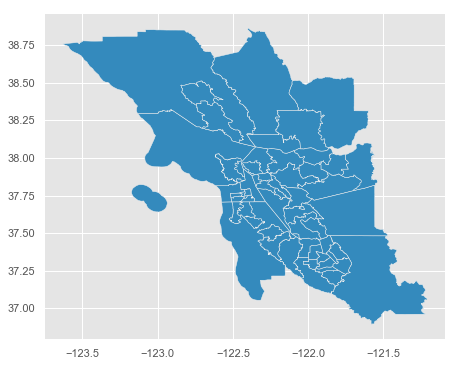

In [58]:
## load file relating PUMAs to CSAs
## I only use this for visualization; it is not actually used downstream.

uspumas=gpd.read_file(os.path.join(drop,'Documents/Data/GIS/Census/PUMAs/2010/tl_2015_00_puma10_merged.shp'))

uspumas['CSA']=uspumas.GEOID10.map(puma_x_csa_map)
uspumas['CSA']=uspumas['CSA'].fillna('Outside CSA')
uspumas['STCOUNTY']=uspumas.GEOID10.str.slice(0,5)

uspumas.loc[uspumas.CSA.str.contains('San Francisco Bay Area$')].plot()

### Define various convenience functions

In [41]:
## adapted from @PiHalbe at http://stackoverflow.com/a/28720410/453343

def weighted_quantile_df(df, val, quantiles, wgt, values_sorted=False, old_style=False,check_recs=False):
    
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of initial array
    :param old_style: if True, will correct output to be consistent with numpy.percentile.
    :return: pandas series with computed quantiles.
    """
     
    quantile_names = ["quant_{qt:.0f}".format(qt=x*100) for x in quantiles]
    #values = numpy.array(values)
    df = df[~df[val].isnull()].copy()
    values = df[val].values
    quantiles = numpy.array(quantiles)
    sample_weight = df[wgt].values
    assert numpy.all(quantiles >= 0) and numpy.all(quantiles <= 1), 'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]
    weighted_quantiles = sample_weight.cumsum() - 0.5 * sample_weight
    weighted_quantiles /= sample_weight.sum()
    
    if check_recs:
        return df.shape[0]
    return pd.Series(np.interp(quantiles, weighted_quantiles, values),index=quantile_names)
    #return numpy.interp(quantiles, weighted_quantiles, values)

## from @PiHalbe at http://stackoverflow.com/a/28720410/453343

def weighted_quantile(values, quantiles, sample_weight=None, values_sorted=False, old_style=False):
    
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of initial array
    :param old_style: if True, will correct output to be consistent with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    
    if len(values)>0:
        values = numpy.array(values)
        quantiles = numpy.array(quantiles)
        if sample_weight is None:
            sample_weight = numpy.ones(len(values))
        sample_weight = numpy.array(sample_weight)
        assert numpy.all(quantiles >= 0) and numpy.all(quantiles <= 1), 'quantiles should be in [0, 1]'

        if not values_sorted:
            sorter = numpy.argsort(values)
            values = values[sorter]
            sample_weight = sample_weight[sorter]

        weighted_quantiles = numpy.cumsum(sample_weight) - 0.5 * sample_weight
        if old_style:
            # To be convenient with numpy.percentile
            weighted_quantiles -= weighted_quantiles[0]
            weighted_quantiles /= weighted_quantiles[-1]
        else:
            weighted_quantiles /= numpy.sum(sample_weight)
        return numpy.interp(quantiles, weighted_quantiles, values)
    else: 
        return np.nan

## GINI function adapted to dataframes from from 
## https://stackoverflow.com/a/49571213/453343
    
def gini_df(df, val,w=None):

    x = np.asarray(df[val])
    if df[w] is not None:
        w = np.asarray(df[w])
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        
        # Force float dtype to avoid overflows
        cumw = np.cumsum(sorted_w, dtype=float)
        cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) / 
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(sorted_x, dtype=float)
        # The above formula, with all weights equal to 1 simplifies to:
        return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n
    
def rescale(s,new_range_low=1000,new_range_hi=10000,intercept=.5):
    """scale each observation according to its relative location within the distribution.
    """

    ## center it around 1
    x=((s-s.min())*(new_range_hi-new_range_low))/(s.max()-s.min())
    #x=((s-s.mean()))/(s.max()-s.min())
    return x+new_range_low

In [42]:
## function to be passed by groupby.apply to returned weighted estimate - does replicate weights standard errors

def weighted_var_SE(frame,var,weight):
    """
    Takes ungrouped observations, splits into groups, applies the logic below, and combines groups into one table. 
    Needs the numeric variable (var) as well as the group by varible (group, as a list) to be passed.
    """
    
    ## A: calculates the weigted value of var x at the level of each observation
    ## main estimate
    #weighted_x = frame.ix[:,weight].mul(frame[var],axis=0)
    weighted_x = frame[weight]*frame[var]

    repwgts=frame.filter(regex=weight+'\d{1,3}').mul(frame[var], axis=0)
    repwgts_estimates=repwgts.sum()/frame.filter(regex=weight+'\d{1,3}').sum()
    
    estimate=weighted_x.sum()/frame[weight].sum()
    
    ## loop through each rep weight column, calculate sq difference with main weight     
    
    squared_difference=0
    for rw in repwgts_estimates:
        squared_difference = squared_difference + (rw - estimate)**2
    
    variance =(4/80.)*squared_difference
    standard_error = (variance)**.5
    coefficient_of_variation = standard_error/estimate
    moe = standard_error * 1.645
    ci_upper = estimate + moe
    ci_lower = estimate - moe
    
    #return pd.DataFrame(data={'Total':primaryWeightSum,'se':standard_error,'coef_det':standard_error/primaryWeightSum})
    ## nov 2015--replaced with series to not have to pass index
    
    samplerecs = frame.shape[0]
    
    output = pd.Series({'estimate':estimate,'ci_upper':ci_upper,'ci_lower':ci_lower if ci_lower>0 else 0 ,
                      'se':standard_error,'moe':moe,'coef_variation':standard_error/estimate,'sample_recs':samplerecs})
    output.index=output.index.astype(CategoricalDtype(categories=['estimate','ci_lower','ci_upper','moe','se','coef_variation','sample_recs'],ordered=True))
    return output.sort_index()
    
def simple_estimate_SE(df,weight='PWGTP',years=1):
    
    
    ## A: calculates the weigted value of var x at the level of each observation
    
    ## col names
    weights = [weight]+df.filter(like=weight, axis=1).columns.tolist()

    
    ## 1: calculate 81 estimates (the last 80 being replicates)
    ## sums weights for subset of records for each replicate
    
    estcol = df.ix[:,weights].sum(axis=0)
    
    ## 2: Store primary weight separately
    primary = estcol[weight] / (years*1.)
      
    squared_difference=0
    
    primaryWeightSum = primary
    #replicateWeightsSum =pd.Series(estcol).sum() 
    
    ## loop through each rep weight column, calculate sq difference with main weight     
    
    for est in estcol.iloc[1:]:
        squared_difference = squared_difference + (est/(years*1.) - primaryWeightSum)**2
    
    variance =(4/80.)*squared_difference
    standard_error = (variance)**.5
    coefficient_of_variation = standard_error/primaryWeightSum
    moe = standard_error * 1.645
    ci_upper = np.ceil(primaryWeightSum + moe)
    ci_lower = np.ceil(primaryWeightSum - moe)
    
    #return pd.DataFrame(data={'Total':primaryWeightSum,'se':standard_error,'coef_det':standard_error/primaryWeightSum})
    ## nov 2015--replaced with series to not have to pass index
    
    samplerecs = df.shape[0]
    
    return pd.Series({'Total':int(primaryWeightSum),'ci_upper':ci_upper,'ci_lower':ci_lower if ci_lower>0 else 0 ,
                      'se':standard_error,'moe':moe,'coef_variation':standard_error/primaryWeightSum,'sample_recs':samplerecs})

def group_median(frame,var,group):
    ## calculate 81 estimates (the last 80 being replicates)
    #val= pd.DataFrame(data={var:rep_estimate},ignore_index=True)
    estcol = [] # weight collection
    primary=[] # holder of the main estimate
    
    ## expanded array
    #weighted_x = frame[w]*frame[var]  
    #repl_estimate=weighted_x.sum()/frame[w].sum()
    #estcol.append(repl_estimate)

    #print "recs in grp %s: %s--now calculating estimate for weight %s" %('-'.join([str(k) for k in (frame.iloc[0,group].values.tolist())]),frame[var].shape[0],w)
    val_sorted=pd.Series(np.repeat(frame[var].values.tolist(), frame.PWGTP.values.tolist())).sort_values(inplace=False)#iloc[]

    ## find midpoint
    if val_sorted.shape[0] % 2==0:
        wm= (val_sorted.iloc[(val_sorted.shape[0]/2)]+
            val_sorted.iloc[(val_sorted.shape[0]/2)+1])/2
    else:
        wm = val_sorted.iloc[val_sorted.shape[0]/2]
    
    return pd.Series({var:[wm],
                              'recs':frame.shape[0],'pop':frame['PWGTP'].sum()})

In [43]:
def simple_estimate_SE(df,weight='PWGTP',years=1):
    
    """
    applied to groupby object (frame is self). 
    Takes ungrouped observations, splits into groups, applies the logic below, and combines groups into one table. 
    Needs the numeric variable (var) as well as the group by varible (group, as a list) to be passed.
    
    :param var: value to be weighted, e.g. income
    :param weight: weight to be summed (i.e. counting observations, not weighting some var)
    
    :return: pandas series
    """
    
    ## A: calculates the weigted value of var x at the level of each observation
    
    ## col names
    estcol = df.filter(regex=weight).sum()
    
    ## 2: Store primary weight separately
    primary = estcol[weight] / (years*1.)
      
    squared_difference=0
    
    primaryWeightSum = primary
    
    ## loop through each rep weight column, calculate sq difference with main weight     
    
    for est in estcol.iloc[1:]:
        squared_difference = squared_difference + (est/(years*1.) - primaryWeightSum)**2
    
    variance =(4./80.)*squared_difference
    standard_error = (variance)**.5
    coefficient_of_variation = standard_error/primaryWeightSum
    moe = standard_error * 1.645  ## reflects a 90% moe assumption per the census bureau
    ci_upper = np.ceil(primaryWeightSum + moe)
    ci_lower = np.ceil(primaryWeightSum - moe)
    
    samplerecs = df.shape[0]
    
    return pd.Series({'estimate':int(primaryWeightSum),'ci_upper':ci_upper,'ci_lower':ci_lower if ci_lower>0 else 0 ,
                      'se':standard_error,'coef_variation':standard_error/primaryWeightSum,'sample_recs':samplerecs})

def group_median_SE_ALT(frame,var,percentile,weight='PWGTP',SE=True):
    
    #percentile = 50
    out = {}
    for perc in percentile:
        frame = frame[~frame[var].isnull()].copy()

        ## calculate 81 estimates (the last 80 being replicates)
        estcol_median =[]
        primary=[] # holder of the main estimate

        weights = [weight]+frame.filter(like=weight, axis=1).columns.tolist()
        
        ## expanded, sort array according to main, replicate weights

        for w in weights: ##passing vertical series, getting back just a scalar
            wm =weighted_quantile(frame[var].values,perc/100.,frame[w].values)
            #print wm,
            ## wm is a scalar not a vector, so after loop we will have 81 estimates in list
            estcol_median.append(wm)

        ## just grab the primary weight for simplicity so we don't confuse with the replicates
        primary = estcol_median[0]
        
        if SE:
            ## then adjust the weight colleciton so it is just the replicates
            estcol_median=estcol_median[1:]

            squared_difference_median=0

            ## loop through each rep weight column, calculate sq difference with main weight     

            squared_difference_median = np.sum((np.asarray(estcol_median)-np.asarray(primary))**2)
            variance_median =(4/80.)*squared_difference_median
            standard_error_median = ((variance_median)**.5)

            coefficient_of_variation_median = 1.*standard_error_median/primary

            moe = standard_error_median * 1.645
            ci_upper = primary + moe #np.ceil(primary + moe)
            ci_lower = primary - moe #np.ceil(primary - moe)

            #print primaryWeightSum
            out['percentile_%s'%perc]= pd.Series({'estimate':primary,
                                      #var+'_mean':[estcol_mean[0]],
                                      'se_median':standard_error_median,#/1*1,
                                      #'se_mean':standard_error_mean,
                                      'cv_median':coefficient_of_variation_median,
                              'ci_upper':ci_upper,'ci_lower':ci_lower if ci_lower>0 else 0,

                                      'recs':frame.shape[0],'pop':frame[weight].sum()})
        else:
            

            out['percentile_%s'%perc]= pd.Series({'estimate':primary,
                                      'recs':frame.shape[0],
                                  'pop':frame[weight].sum()})
    return pd.concat(out)

def group_median_SE_w_ratio(frame,var,percentile,weight='PWGTP',SE=True):
    """
    calculates 80-20 ratios of var and provides confidence intervals
    """
    #percentile = 50
    out = {}
    pctkeep ={}
    frame = frame[~frame[var].isnull()].copy()

    ## calculate 81 estimates (the last 80 being replicates)
    estcol_median =[]
    primary=[] # holder of the main estimate

    weights = [weight]+frame.filter(like=weight, axis=1).columns.tolist()
    #return frame[weights[1]].sum(axis=0)
    ## expanded, sort array according to main, replicate weights
    #return frame[var].values
    for w in weights: ##passing vertical series, getting back just a scalar
        for perc in percentile:
            wm =weighted_quantile(frame[var].values,perc/100.,frame[w].values)
            #print w,wm
            pctkeep[(w,perc)]=wm
            ## wm is a scalar not a vector, so after loop we will have 81 estimates in list
            #estcol_median.append(wm)
    result_1 = pd.Series(pctkeep)
    result_1=result_1.swaplevel(1,0)
    result_2 = result_1.xs(np.max(percentile))/result_1.xs(np.min(percentile))
    
    ## Standard errors
    ## loop through each rep weight column, calculate sq difference with main weight     

    squared_difference_median = np.sum((np.asarray(result_2[1:])-np.asarray(result_2[0]))**2)
    variance_median =(4/80.)*squared_difference_median
    standard_error_median = ((variance_median)**.5)

    coefficient_of_variation_median = 1.*standard_error_median/result_2[0]

    moe = standard_error_median * 1.645
    ci_upper = result_2[0] + moe #np.ceil(primary + moe)
    ci_lower = result_2[0] - moe #np.ceil(primary - moe)

    #print primaryWeightSum
    out = pd.Series({'estimate':result_2[0],
                              #var+'_mean':[estcol_mean[0]],
                              #'se_median':int(standard_error_median/1)*1,
                              #'se_mean':standard_error_mean,
                              #'cv_median':coefficient_of_variation_median,
                              'ci_upper':ci_upper,'ci_lower':ci_lower if ci_lower>0 else 0,

                              'recs':frame.shape[0],'pop':frame[weight].sum()})
    return out

In [44]:
import re, io, numpy as np
from cStringIO import StringIO 
    
def map_value_labels(codes_pasted,var):
    """
    Reads pasted id:value correspondence and prepares a 
    id:value dictionary to be used for mapping
    """
    
    ## substitute out dots and leading space
    codes_pasted = re.sub(r' \.','\t', codes_pasted)
    
    ## read code string as if it were a file object, store in dataframe
    df_codes = pd.read_csv(StringIO(codes_pasted), 
                           encoding='utf8', sep="\t",
                           header=None if os.name=='posix' else None,
                           names=['id','value'],
                           dtype={'id': object, 'value': object})
    
    df_codes['value']=df_codes['value'].apply(lambda x: str(x).strip())
    
    df_codes.index=df_codes.id.astype(np.int64)
    df_codes=df_codes['value'].to_dict()
    #print df_codes
    ## store output in a dict keyed on the variable name, with the codes being the values
    d={}
    d[var]=df_codes
    return d

def assign_value_labels(df,value_map,years=range(2006,2018),target=None):
    """
    performs actual assignment. Takes dataframe and dict from map_value_labels
    """
    ##prepare to write encoding back to data--store in separate variable
    var = value_map.keys()[0]
    
    ## allow for possibility of assigning a different name to the original census variable.
    ## default is just an '_l' suffix, but since we may want to have different codings of the same variable
    ## allowing a separate name is useful.
    
    if target is None:
        target = "%s_l"%var
    print "Adding variable %s to df" %target
    df.ix[df.YEAR.isin(years),target] = df.ix[df.YEAR.isin(years),var].map(value_map[var])   
    
    print df[target].head(2)
    

In [45]:
def agebreaker(breaks,prefix='age'):
    labels=[]
    for f in range(len(breaks)-1):
        labels.append("{prefix}{fr:02.0f}{to:02.0f}".format(fr=breaks[f],to=breaks[f+1]-1,prefix=prefix))
    labels[-1]='{prefix}{dt:,.0f}p'.format(dt=breaks[-2],prefix=prefix)
    return labels

def agebreaker(breaks,prefix='ag',topcode=True):
    labels=[]
    for f in range(len(breaks)-1):
        labels.append("{pre}{fr:02.0f}-{to:02.0f}".format(fr=breaks[f],to=breaks[f+1]-1,pre=prefix))
#difflabels[0]='{dt:,.0f}'.format(dt=diffbreaks[1])
    if topcode:
        labels[-1]='{pre}{dt:.0f}p'.format(dt=breaks[-2],pre=prefix)
        
    return labels
#agebreaker(range(0,86,5),prefix='ag')


def agebreaker2(breaks):
    labels=[]
    for f in range(len(breaks)-1):
        labels.append("Ages {fr:.0f}-{to:.0f}".format(fr=breaks[f],to=breaks[f+1]-1))
    labels[-1]='Ages {dt:,.0f}+'.format(dt=breaks[-2])
    return labels

diffbreaks_5 =range(0,86,5)+[np.inf]
diffbreaks_custom =[0,18,25,45,65,np.inf]
diffbreaks_custom =[0,20,30,65,np.inf]
diffbreaks_coarse =range(20,90,5)+[np.inf]


In [48]:
## various classifications / codings

def place_of_birth(x):
    if x==6:
        return 'Born in CA'
    elif x<100:
        return 'Born in US / terr.'
    else:
        return 'Born abroad'

def nativity(df):
    if df.POBP==6:
        return 'Born in CA'
    elif df.POBP<100:
        return 'Born in US / terr.'
    else: ## abroad
        if df.YEAR-df.YOEP<=20:
            return 'Foreign abroad, lt 20 yrs in US'
        else:
            return 'Foreign abroad, 20+ yrs in US'

def hhsize(s,na_string='GQ/vacant',breaking=4,prefix=''):
    if s==-1:
        return na_string
    if 0 <= s< breaking :
        return "{}{:.0f}".format(prefix,s)
    else:
        return "{}{}".format(prefix,breaking)
    
def has_senior(s):
    if s==-1:
        return 'NA'
    elif s>=65:
        return 'senior householder'
    else:
        return 'no senior householder'
        

def adult_child(df):

    if 2006<= df.YEAR <2008:
        if (df.RELP==2) or (df.RELP==3) :
            if 18 <= df.AGEP <=39:
                return "Young adult children at home"
            else:
                return "Other children at home"
        else:
            return 'No children in home'
    elif df.YEAR>2007:
        if (df.RELP==2) or (df.RELP==3)  or (df.RELP==4):
            if 18 <= df.AGEP <=39:
                return "Young adult children at home"
            else:
                return "Other children at home"
        else:
            return 'No children in home'
def race_eth(df):
    if df.name>1:
        return 'Hispanic'
    else:
        return df+'-NonHispanic'
    

def ami_classifier(df,incvar=['HINCP_adj']):
    """
        very low -        0-50% AMI
        low -        50-80% AMI
        moderate -        80-120% AMI
        high-        120-150% AMI
        very high-        150% and above AMI
    """
    vlow = df[incvar] *.5
    low  = df[incvar] *.8
    moderate = df[incvar] *1.2
    high = df[incvar] *1.5
    return pd.Series(data=[vlow,low,moderate,high])


def label_formatter(breaks,currency=False):
    if breaks[0]!=0:
        breaks.insert(0,0)
    diff=np.diff(breaks).tolist()
    ## make tuples of *breaks* and length of intervals
    joint = list(zip(breaks,diff))
    if currency:
        labels = ["${left:,.0f} to ${right:,.0f}".format(left=yr[0], right=yr[0]+yr[1]-1) for yr in joint]
        s1 = "${left:,.0f} to ${right:,.0f}"
        s2="${left:,.0f} +"
    else:
        labels = ["{left:,.0f} to {right:,.0f}".format(left=yr[0], right=yr[0]+yr[1]-1) for yr in joint]
        s1 = "{left:,.0f} to {right:,.0f}"
        s2="{left:,.0f} +"
    
    
    labels = [s1.format(left=yr[0], right=yr[0]+yr[1]-1) if not np.isinf(yr[1]) else s2.format(left=yr[0]) for yr in joint ]
    return labels

## floats
def floatlabels(s,prec=3):
    #nudge=10 ** -(prec+1)
    nudge=0
    outlist=[]
    i=0
    #for i, x in enumerate(s):
    ## precision passed as parameter
    "{num:,.{prec:}f}$".format(prec=6,num=1000.33333)
    for i in range(len(s)):
        if i==0: ## first item
            ## add outer bound
            outlist.append('LT {num:,.{prec:}f}'.format(num=s[0],prec=prec))
            ## but also add from this item to the next one
            outlist.append('{fr:,.{prec:}f} -> {to:,.{prec:}f}'.format(fr=s[i],to=s[i+1]-nudge,prec=prec))
        elif i==len(s)-1:  ## last item
            outlist.append('{num:,.{prec:}f}+'.format(num=s[-1],prec=prec))
        else:# i<len(s)-2:
            outlist.append('{fr:,.{prec:}f} -> {to:,.{prec:}f}'.format(fr=s[i],to=s[i+1]-nudge,prec=prec))
    return outlist

## floats
def floatlabels(s,prec=3):
    #nudge=10 ** -(prec+1)
    nudge=0
    outlist=[]
    i=0
    #for i, x in enumerate(s):
    ## precision passed as parameter
    "{num:,.{prec:}f}$".format(prec=6,num=1000.33333)
    for i in range(len(s)):
        #if i==0: ## first item
            ## add outer bound
       #     outlist.append('LT {num:,.{prec:}f}'.format(num=s[0],prec=prec))
            ## but also add from this item to the next one
       #     outlist.append('{fr:,.{prec:}f} -> {to:,.{prec:}f}'.format(fr=s[i],to=s[i+1]-nudge,prec=prec))
        #    pass
        if i==len(s)-1:  ## last item
            outlist.append('{num:,.{prec:}f}+'.format(num=s[-1],prec=prec))
        else:# i<len(s)-2:
            outlist.append('{fr:,.{prec:}f} -> {to:,.{prec:}f}'.format(fr=s[i],to=s[i+1]-nudge,prec=prec))
    return outlist
bins=[-np.inf]+list(np.arange(-1,1.1,.5))+[np.inf]
bins=np.arange(-1,1.01,.1)
floatlabels(bins,prec=2)
#np.arange(-1,1.1,.5)
#np.arange(-1,1.01,.05)


bins=[-np.inf]+list(np.arange(-1,1.1,.5))+[np.inf]
bins=np.arange(-1,1.01,.1)
#floatlabels(bins,prec=2)

#### Define data dictionaries, mostly from PUMS data dictionary

In [49]:
codesvacant="""
1 .For rent
2 .Rented, not occupied
3 .For sale only
4 .Sold, not occupied
5 .For seasonal/recreational/occasional use
6 .For migrant workers
7 .Other vacant
"""

codesvacant2="""
1 .Rented
2 .Rented
3 .Owned
4 .Owned
5 .Other vacant
6 .Other vacant
7 .Other vacant
"""

codesvacant2="""
1 .Rented
2 .Other vacant
3 .Owned
4 .Other vacant
5 .Other vacant
6 .Other vacant
7 .Other vacant
"""

## WARNING: VALID FROM 2009 and later. In earlier years, the coding was reverse--"1" was the most recent year,
## so coding switched every year.
codesYBL="""
            01     .1939 or earlier
            02     .1940 to 1949
            03     .1950 to 1959
            04     .1960 to 1969
            05     .1970 to 1979
            06     .1980 to 1989
            07     .1990 to 1999
            08     .2000 to 2004
            09     .2005 to 2018
            10     .2005 to 2018
            11     .2005 to 2018
            12     .2005 to 2018
            13     .2005 to 2018
            14     .2005 to 2018
            15     .2005 to 2018
            16     .2005 to 2018
            17     .2005 to 2018
            18     .2005 to 2018
            19     .2005 to 2018
            20     .2005 to 2018
            21     .2005 to 2018
            22     .2005 to 2018
"""

codesYBL2008="""
01 .2008
02 .2007
03 .2006
04 .2005
05 .2000 to 2004
06 .1990 to 1999
07 .1980 to 1989
08 .1970 to 1979
09 .1960 to 1969
10 .1950 to 1959
11 .1940 to 1949
12 .1939 or earlier
"""
codesYBL2007="""
1 .2005 or later
2 .2000 to 2004
3 .1990 to 1999
4 .1980 to 1989
5 .1970 to 1979
6 .1960 to 1969
7 .1950 to 1959
8 .1940 to 1949
9 .1939 or earlier
"""
codesYBL2006="""
 1 .2005 or later
 2 .2000 to 2004
 3 .1990 to 1999
 4 .1980 to 1989
 5 .1970 to 1979
 6 .1960 to 1969
 7 .1950 to 1959
 8 .1940 to 1949
 9 .1939 or earlier
"""
milit="""
1 .Now on active duty
2 .On active duty in the past, but not now
3 .Only on active duty for training in Reserves/National Guard
4 .Never served in the military
"""
## REMI doesn't have much race detail, so we don't either.
codesraceREMI ="""
1 .White
2 .Black
3 .Other
4 .Other
5 .Other
6 .Other
7 .Other
8 .Other
9 .Other
"""

## RACE
## note that these are not actually verbatim categories from the code book. Instead, this collapses categories.
codesrace ="""
1 .White
2 .Black
3 .Other
4 .Other
5 .Other
6 .Asian
7 .Other
8 .Other
9 .Two + Races
"""

bldcodes="""
01 .Other
02 .One-family house
03 .One-family house
04 .2 Apartments
05 .3-10 Apartments
06 .3-10 Apartments
07 .10-49 Apartments
08 .10-49 Apartments
09 .50 or more apartments
10 .Other
"""

# MIG

migstatus="""
1 .Yes, same house (nonmovers) 
2 .No, outside US and Puerto Rico 
3 .No, different house in US or Puerto Rico 
"""

# HUPAC
presenceofchildren="""
1 .With children under 6 years only 
2 .With children 6 to 17 years only 
3 .With children under 6 years and 6 to 17 years 
4 .No children 
"""

# FES
familytype=""" 
1 .Married-couple family: Husband and wife in LF 
2 .Married-couple family: Husband in labor force, wife not in LF 
3 .Married-couple family: Husband not in LF, wife in LF 
4 .Married-couple family: Neither husband nor wife in LF 
5 .Other family: Male householder, no wife present, in LF 
6 .Other family: Male householder, no wife present, not in LF 
7 .Other family: Female householder, no husband present, in LF 
8 .Other family: Female householder, no husband present, not in LF     
"""

## don't use--these codes change all the time so we need multiple dictionaries for the years
educ="""
01 .No schooling completed
02 .Nursery school, preschool   
03 .K-8
04 .K-8
05 .K-8
06 .K-8              
07 .K-8
08 .K-8
09 .K-8
10 .K-8      
11 .K-8
12 .High school, unfinished
13 .High school, unfinished
14 .High school, unfinished                   
15 .High school, unfinished
16 .High school or equiv
17 .High school or equiv
18 .Some college
19 .Some college
20 .Associate's degree                           
21 .Bachelor's degree
22 .Master's degree
23 .Professional degree beyond a bachelor's degree
24 .Doctorate degree
"""

codemovein="""
1 .Less than 2 years
2 .Less than 2 years
3 .2 to 4 years
4 .5 to 9 years
5 .10 years or more
6 .10 years or more
7 .10 years or more
"""

codesrelationship = """

00 .Reference person
01 .Husband/wife
02 .Biological son or daughter
03 .Adopted son or daughter
04 .Stepson or stepdaughter
05 .Brother or sister
06 .Father or mother
07 .Grandchild
08 .Parent-in-law
09 .Son-in-law or daughter-in-law
10 .Other relative
11 .Roomer or boarder
12 .Housemate or roommate
13 .Unmarried partner
14 .Foster child
15 .Other nonrelative
16 .Institutionalized group quarters population
17 .Noninstitutionalized group quarters population
"""
codesJTW="""
02 .Bus or streetcar 
01 .Car, truck, or van 
03 .Bus or streetcar 
04 .Subway or railroad 
05 .Subway or railroad
06 .Other method         
07 .Other method 
08 .Other method  
09 .Bicycle 
10 .Walked 
11 .Worked at home 
12 .Other method 
 """

codes_ten = """
1 .Owned (mortgage or loan)
2 .Owned free and clear
3 .Rented
4 .Occupied w/O rent
"""
codes_ten = """
1 .Owned
2 .Owned
3 .Rented
4 .Occupied w/O rent
"""

codescow="""
           1 .Private Wage and Salary employee
           2 .Non-Profit Wage and Salary employee
           3 .Local government employee
           4 .State government employee
           5 .Federal government employee
           6 .Self-employed in own not incorporated business
           7 .Self-employed in own incorporated business
           8 .Working without pay in family business or farm
           9 .Unemployed and last worked 5 years ago or earlier or never worked
"""

codesESRcoarse="""
           1 .Civilian employed, at work
           2 .Civilian employed, with a job but not at work
           3 .Unemployed
           4 .Armed forces, at work
           5 .Armed forces, with a job but not at work
           6 .NILF
"""

codesESR ="""
1 .Civilian employed, at work 
2 .Civilian employed, with a job but not at work 
3 .Unemployed 
4 .Armed forces, at work 
5 .Armed forces, with a job but not at work 
6 .Not in labor force 
"""

codesESR2="""
           1 .Civilian employed
           2 .Civilian employed
           3 .Unemployed
           4 .Armed forces
           5 .Armed forces
           6 .NILF
"""

codesLNGI="""
            1 .Person 14+ in HH speaks Eng very well
            2 .No Person 14+ in HH speaks Eng very well
"""

codesSCHL_pre2008="""
           01 .No school completed
           02 .Nursery school to grade 4   
           03 .Grade 5 or grade 6
           04 .Grade 7 or grade 8
           05 .Grade 9
           06 .Grade 10                   
           07 .Grade 11  
           08 .Grade 12 no diploma    
           09 .High school graduate                
           10 .Some college, but less than 1 year
           11 .One or more years of college, no degree
           12 .Associate's degree                           
           13 .Bachelor's degree 
           14 .Master's degree
           15 .Professional school degree
           16 .Doctorate degree 
"""
codesSCHL_2008p="""
		01 .No school completed
		02 .Nursery school to grade 4
		03 .Nursery school to grade 4
		04 .Nursery school to grade 4
		05 .Nursery school to grade 4
		06 .Nursery school to grade 4
		07 .Nursery school to grade 4
		08 .Grade 5 or grade 6
		09 .Grade 5 or grade 6
		10 .Grade 7 or grade 8
		11 .Grade 7 or grade 8
		12 .Grade 9
		13 .Grade 10
		14 .Grade 11
		15 .Grade 12 no diploma
		16 .High school graduate
		17 .High school graduate
		18 .Some college, but less than 1 year
		19 .One or more years of college, no degree
		20 .Associate's degree
		21 .Bachelor's degree
		22 .Master's degree
		23 .Professional school degree
		24 .Doctorate degree
"""
codesSCHL_2008p_orig="""
		01 .No schooling completed
		02 .Nursery school, preschool   
		03 .Kindergarten
		04 .Grade 1
		05 .Grade 2
		06 .Grade 3
		07 .Grade 4
		08 .Grade 5
		09 .Grade 6
		10 .Grade 7
		11 .Grade 8  
		12 .Grade 9
		13 .Grade 10
		14 .Grade 11
		15 .12th grade - no diploma   
		16 .Regular high school diploma
		17 .GED or alternative credential
		18 .Some college, but less than 1 year
		19 .1 or more years of college credit, no degree
		20 .Associate's degree
		21 .Bachelor's degree
		22 .Master's degree
		23 .Professional degree beyond a bachelor's degree
		24 .Doctorate degree
"""

In [50]:
###########################################################
vacant_value_map = map_value_labels(codesvacant,'VACS')
vacant_value_map2 = map_value_labels(codesvacant2,'VACS')
esr_value_map = map_value_labels(codesESR2,'ESR')
cow_value_map = map_value_labels(codescow,'COW')
race_value_map = map_value_labels(codesrace,'RAC1P')
remirace_value_map = map_value_labels(codesraceREMI,'RAC1P')
move_value_map = map_value_labels(codemovein,'MV')
rel_value_map = map_value_labels(codesrelationship,'RELP')
ten_value_map = map_value_labels(codes_ten,'TEN')
mil_value_map = map_value_labels(milit,'MIL')
bld_value_map = map_value_labels(bldcodes,'BLD')
jtw_value_map = map_value_labels(codesJTW,'JWTR')
chld_value_map = map_value_labels(presenceofchildren,'HUPAC')
famtype_value_map = map_value_labels(familytype,'FES')
mig_value_map = map_value_labels(migstatus,'MIG')
ybl_value_map = map_value_labels(codesYBL,'YBL')
ling_value_map = map_value_labels(codesLNGI,'LNGI')
schl_a_value_map = map_value_labels(codesSCHL_pre2008,'SCHL')
schl_b_value_map = map_value_labels(codesSCHL_2008p,'SCHL')


### Prep Person file

In [51]:
p_allvarkeep=['ST','PUMA','NP','PWGTP','MIG']

In [52]:
persons_a=pd.read_csv(os.path.join(drop,'Documents/Data/_Census/ACS/ACS_2018_1Year_US/PUMS/ss18pusa.csv'))
persons_b=pd.read_csv(os.path.join(drop,'Documents/Data/_Census/ACS/ACS_2018_1Year_US/PUMS/ss18pusb.csv'))

In [53]:
persons = pd.concat([persons_a,persons_b])

del persons_a
del persons_b

In [59]:
persons['STPUMA']=persons.ST.apply(lambda x: '{:0>2}'.format(x))+persons.PUMA.apply(lambda x: '{:0>5}'.format(x))
persons['CSA']=persons.STPUMA.map(puma_x_csa_map)
persons.CSA=persons.CSA.replace({'San Jose-San Francisco-Oakland, CA','San Francisco Bay Area Halo'}).fillna('Outside CSA')#.astype('category')
persons['CBSA']=persons.STPUMA.map(puma_x_cbsa_map)

In [60]:
## BE CAREFUL - remember there is a different logic for STPUMA to county relations on the east coast - 
## Only use for CA tabulations

persons['STCOUNTY']=persons['STPUMA'].str.slice(0,5)

### Prep Household file

In [61]:
households_a=pd.read_csv(os.path.join(drop,'Documents/Data/_Census/ACS/ACS_2018_1Year_US/PUMS/ss18husa.csv'))
households_b=pd.read_csv(os.path.join(drop,'Documents/Data/_Census/ACS/ACS_2018_1Year_US/PUMS/ss18husb.csv'))

In [62]:
households = pd.concat([households_a,households_b])

del households_a
del households_b

In [63]:
households['STPUMA']=households.ST.apply(lambda x: '{:0>2}'.format(x))+households.PUMA.apply(lambda x: '{:0>5}'.format(x))
households['CSA']=households.STPUMA.map(puma_x_csa_map)
households.CSA=households.CSA.replace({'San Jose-San Francisco-Oakland, CA','Bay Area Vicinity'})

households['CSA']=households['CSA'].fillna('Outside CSA')#.astype('category')
households['CBSA']=households.STPUMA.map(puma_x_cbsa_map)
households['CBSA']=households['CBSA'].fillna('Outside CBSA').astype('category')

In [64]:
households['STCOUNTY']=households['STPUMA'].str.slice(0,5)

In [65]:
persons['POWSP2']=None
persons.loc[persons.POWSP.notnull(),'POWSP2']=persons.loc[persons.POWSP.notnull(),'POWSP'].apply(lambda x: '{:0>3}'.format(int(x)))

persons['POWPUMA2']=None
persons.loc[persons.POWPUMA.notnull(),'POWPUMA2']=persons.loc[persons.POWPUMA.notnull(),'POWPUMA'].apply(lambda x: '{:0>5}'.format(int(x)))

persons['POWSTPUMA']=None
persons.loc[persons.POWPUMA2.notnull(),'POWSTPUMA']=persons.loc[persons.POWSP2.notnull(),'POWSP2']+persons.loc[persons.POWPUMA2.notnull(),'POWPUMA2']

In [66]:
persons['MIGSP2']=None
persons.loc[persons.MIGSP.notnull(),'MIGSP2']=persons.loc[persons.MIGSP.notnull(),'MIGSP'].apply(lambda x: '{:0>3}'.format(int(x)))

persons['MIGPUMA2']=None
persons.loc[persons.MIGPUMA.notnull(),'MIGPUMA2']=persons.loc[persons.MIGPUMA.notnull(),'MIGPUMA'].apply(lambda x: '{:0>5}'.format(int(x)))

persons['MIGSTPUMA']=None
persons.loc[persons.MIGPUMA2.notnull(),'MIGSTPUMA']=persons.loc[persons.MIGSP2.notnull(),'MIGSP2']+persons.loc[persons.MIGPUMA2.notnull(),'MIGPUMA2']

In [67]:
persons['MIGCSA']=persons.MIGSTPUMA.map(migpumacodes.groupby('MIGSTPUMA').CSA.first())
persons['MIGCBSA']=persons.MIGSTPUMA.map(migpumacodes.groupby('MIGSTPUMA').CBSA.first())
persons['MIGSTCOUNTY']=persons.MIGSTPUMA.map(migpumacodes.groupby('MIGSTPUMA').STCOUNTY.first())

In [68]:
persons['movestatus']='Nonmover'

persons.loc[(persons.MIGCSA!=persons.CSA)&(persons.MIG.isin([2,3])),'movestatus']='Moved from outside region'
persons.loc[(persons.MIGCSA==persons.CSA),'movestatus']='Moved within region'
persons.loc[(persons.MIG.isin([1])),'movestatus']='Nonmover'

## since we dont use the official Bay Area CSA name, but instead say "San Francisco Bay Area"
## we won't have any within-region movers since that criteria will always fail. We handle separately
persons.loc[(persons.STCOUNTY.isin(bayareafips_full))
             &(persons.MIGSTCOUNTY==persons.STCOUNTY),'movestatus']='Moved within region'

In [69]:
persons['FMR_CODE']=persons.STPUMA.map(stpuma_x_fmrcode)
households['FMR_CODE']=households.STPUMA.map(stpuma_x_fmrcode)

In [70]:
#persons.loc[(persons.MIGCSA!=persons.CSA)].groupby(['MIGCSA','CSA']).PWGTP.sum().loc[:,'San Jose-San Francisco-Oakland, CA']

### Variable assignments and classifications

In [ ]:
mtcbins = [30000,60000,100000,np.inf]
persbins=[10000,25000,50000,100000,np.inf]
label_formatter(mtcbins)
finer_bins = [20000,35000,50000,75000,100000,150000,200000,np.inf]
coarse_bins = [50000,100000,200000,np.inf]
rent_bins = [0,200,500,750,1000,1500,np.inf]
label_formatter(persbins,currency=True)

mtcbins = [30000,60000,100000,np.inf]
label_formatter(mtcbins)
finer_bins = [0,20000,35000,50000,75000,100000,150000,200000,np.inf]

In [73]:
households['county']=households['County']=households.STPUMA.str.slice(0,5).map(bayareafips_full)+' County'

In [71]:
households['inc_cat_fine']=pd.cut(households.HINCP.fillna(0),finer_bins,labels=label_formatter(finer_bins,currency=True))
households['inc_cat_fine']=households['inc_cat_fine']#.cat.add_categories('NA')
households['inc_cat_fine']=households['inc_cat_fine'].cat.reorder_categories(label_formatter(finer_bins,currency=True))
persons['pinc_cat_coarse']=pd.cut(persons.PINCP,persbins,labels=label_formatter(persbins,currency=True) )
persons['pinc_cat_fine']=pd.cut(persons.PINCP.fillna(0),finer_bins,labels=label_formatter(finer_bins,currency=True))
persons['pinc_cat_fine']=persons['pinc_cat_fine'].cat.add_categories('NA')
persons['pinc_cat_fine']=persons['pinc_cat_fine'].fillna('NA').cat.reorder_categories(label_formatter(finer_bins,currency=True)+['NA'])

In [72]:
households['inc_cat_coarse']=pd.cut(households.HINCP.fillna(0),coarse_bins,labels=label_formatter(coarse_bins,currency=True))
households['inc_cat_coarse']=households['inc_cat_coarse']#.cat.add_categories('NA')
households['inc_cat_coarse']=households['inc_cat_coarse'].cat.reorder_categories(label_formatter(coarse_bins,currency=True))

#### Crowding, vacancy and cost burden variables

In [402]:
roombins=np.arange(0,4.01,.25)
roomlabels=floatlabels(roombins,prec=2)

households['rooms']=pd.to_numeric(households.RMSP,errors='coerce')
households['pers_per_room']=households.NP.replace({0:np.nan})/households.rooms
households['pers_per_room_cat']=pd.cut(households.pers_per_room,roombins,labels=floatlabels(roombins,prec=2)[:-1])

households['rooms_less_persons']=households.rooms-households.NP.replace({0:np.nan})
households['rooms_less_persons_cat']=pd.cut(households.rooms_less_persons,[-20,-10,-8,-6,-4,-2,-1,20],right=True,
                                         #labels=['Deficit 10 or more','Deficit 9-10','Deficit 7-8','Deficit 5-6', 'Deficit 4-5','Deficit 2-3','Deficit 0-1','0','Surplus']
                                           labels=['Deficit 10 or more','Deficit 8-9','Deficit 6-7','Deficit 4-5', 'Deficit 2-3','Deficit 1','Surplus']
                                           )

households['room_cat']=pd.cut(households.rooms,[1,4,6,8,20],labels=['1-4','5-6','7-8','9+'])
households['is_crowded']=households.pers_per_room>1

In [550]:
households['vac_status']=households.VACS.map(vacant_value_map['VACS']).fillna('Not Vacant')#.astype('category')

## vacancy numerator
households['vac_status_gen']=households.VACS.map(vacant_value_map2['VACS']).fillna('Not Vacant')#.astype('category')

households.groupby(['vac_status','vac_status_gen']).WGTP.sum()

vac_status                                vac_status_gen
For migrant workers                       Other vacant          40820
For rent                                  Rented              2901215
For sale only                             Owned               1207670
For seasonal/recreational/occasional use  Other vacant        5423645
Not Vacant                                Not Vacant        121520185
Other vacant                              Other vacant        6177645
Rented, not occupied                      Other vacant         602000
Sold, not occupied                        Other vacant         666726
Name: WGTP, dtype: int64

In [549]:
#households['is_vacant']=households.VACS.isin(range(1,8))
households['is_vacant']=households.VACS.isin([1,3]) ## limit types of vacancies that count

persons['JWTR_l']=persons.JWTR.map(jtw_value_map['JWTR'])
households['TEN_l']=households.TEN.map(ten_value_map['TEN'])

households['TEN_l']=households['TEN_l'].fillna('VAC/GQ')

In [551]:
## DENOMINATOR for share vacant by tenure

# a) occupied rental and owned units PLUS
# b) vacant rental and owned units

households['ten_univ']='VAC/GQ'
households.loc[households.vac_status.str.contains('ent'),'ten_univ']='Rented'
households.loc[households.vac_status.str.contains('sale|Sold'),'ten_univ']='Owned'
households.loc[households.TEN_l.str.contains('ent'),'ten_univ']='Rented'
households.loc[households.TEN_l.str.contains('Owned'),'ten_univ']='Owned'

In [407]:
households['yr_blt']=households.YBL.map(ybl_value_map['YBL'])

In [405]:
persons['age_fine']=pd.cut(persons.AGEP, right=False,bins=diffbreaks_5,labels=agebreaker(diffbreaks_5,prefix=''))
persons['age_coarse']=pd.cut(persons.AGEP, right=False,bins=diffbreaks_custom,labels=agebreaker(diffbreaks_custom,prefix=''))

In [409]:
## add race / ethnicity
persons['race_remi']=persons.RAC1P.map(remirace_value_map['RAC1P'])
persons['rac_ethn_remi']=persons.groupby(['HISP'])['race_remi'].transform(race_eth)
households['rac_ethn_remi']=households.SERIALNO.map(persons.loc[persons.RELP==0].set_index('SERIALNO').rac_ethn_remi)

In [412]:
persons['in_labor_force']=persons.ESR.isin(range(1,6)).map({True:'In Labor Force',False:'Not in Labor Force'})

In [413]:
## family size specific FPL guideline for 2018 https://aspe.hhs.gov/2018-poverty-guidelines

fpl=pd.Series({1.0: 12140,
 2.0: 16460,
 3.0: 20780,
 4.0: 25100,
 5.0: 29420,
 6.0: 33740,
 7.0: 38060,
 8.0: 42380})
fpl_plus=lambda x: 42380+x*4320

In [414]:
households['fpl']=None
households.loc[households.NP>8,'fpl']=households.loc[households.NP>8].NP.map(fpl_plus)
households.loc[households.NP<=8,'fpl']=households.loc[households.NP<=8].NP.map(fpl)

households['hinc_belov_fpl']=households.HINCP<households.fpl
households['hinc_2x_belov_fpl']=households.HINCP<households.fpl*2.0

In [415]:
## housing costs
pd.options.display.float_format = '{:,.0f}'.format
## what do recent movers pay for housing, 2006-2014?

In [416]:
households['rent_to_hinc']=households.GRNTP/(households.HINCP/12.)

In [417]:
households['hsgcost_to_hinc']=None

households.loc[:,['GRPIP','OCPIP']]=households.loc[:,['GRPIP','OCPIP']].convert_objects(convert_numeric=True)
households.loc[households.GRPIP.notnull(),'hsgcost_to_hinc']=households.loc[households.GRPIP.notnull()].GRPIP.fillna(0)
households.loc[households.OCPIP.notnull(),'hsgcost_to_hinc']=households.loc[households.OCPIP.notnull()].OCPIP.fillna(0)
households.loc[households.hsgcost_to_hinc.isnull(),'hsgcost_to_hinc']='NA'

/Users/aolsen/anaconda2/envs/geoenv/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [583]:
## categorize cost ratios

pd.options.display.float_format = '{:,.0f}'.format

hhincbinspct = range(0,51,10)+[np.inf]
households['rent_to_hinc_cat'] = pd.cut(households.rent_to_hinc*100,hhincbinspct,right=False,
                                        labels=['%s pct' %x for x in label_formatter(hhincbinspct)] )
households['hsgcost_to_hinc_cat'] = pd.cut(households.hsgcost_to_hinc,hhincbinspct,right=False,
                                        labels=['%s pct' %x for x in label_formatter(hhincbinspct)] )

In [584]:
households['is_cost_burdened']=households['hsgcost_to_hinc_cat'].isin(['30 to 39 pct','40 to 49 pct','50 + pct'])

In [ ]:
hsgcost=households.groupby(['CSA','TEN_l','hsgcost_to_hinc_cat']).apply(simple_estimate_SE,weight='WGTP')

In [585]:
hsgcost.loc(0)['San Francisco Bay Area','Rented']

,ci_lower,ci_upper,coef_variation,estimate,sample_recs,se
hsgcost_to_hinc_cat,,,,,,
0 to 9 pct,"58,607","67,476",0,"63,041",607,"2,696"
10 to 19 pct,"249,347","270,072",0,"259,709","2,339","6,299"
20 to 29 pct,"279,826","300,365",0,"290,095","2,611","6,243"
30 to 39 pct,"159,262","174,939",0,"167,100","1,453","4,765"
40 to 49 pct,"93,010","106,459",0,"99,734",842,"4,088"
50 + pct,"256,027","277,128",0,"266,577","2,283","6,414"


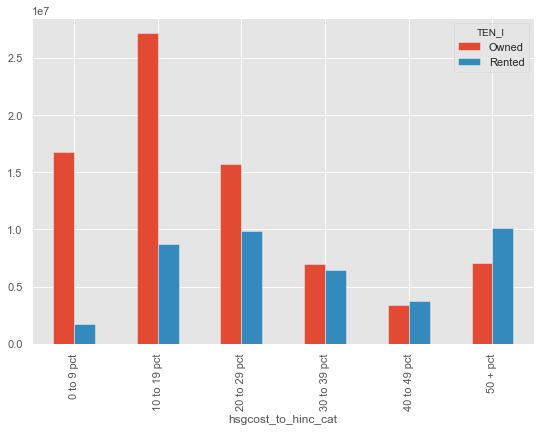

In [424]:
households.groupby(['TEN_l','hsgcost_to_hinc_cat']).WGTP.sum().unstack(0).plot(kind='bar')

#### Assign metro-specific HUD income limits to household file across the nation

https://www.hudexchange.info/programs/home/home-income-limits/


> Family sizes in excess of 8 persons are calculated by adding 8% of the four-person income limit for each additional family member. That is, a 9-person limit should be 140% of the 4-person limit, the 10-person limit should be 148%.

In [77]:
inccatmap={30:u'Extremely Low',
 50:u'Very Low Income',
 80:u'Low Income',
 120:u'Moderate Income',
# np.inf:'Above Moderate Income'
}

In [78]:
### Read in HUD Income Limits at the county level from the national file

inclim = pd.read_excel(os.path.join(drop,'Documents/Data/_HUD/INCOME_LIMITS/HOME_IncomeLmts_Natl_2018.xlsx'),converters={'fips2010':str})

inclim['STCOUNTY']=inclim.State.apply(lambda x: '{:0>2}'.format(x))+inclim.County.apply(lambda x: '{:0>3}'.format(x))
inclim=inclim.drop(['State','statename','County'],axis=1)

inclim=inclim.set_index([u'fips2010', 'STCOUNTY', u'cbsasub', u'areaname'])
inclim=inclim.stack().reset_index(name='value').rename(columns={'level_4':'variable','fips2010':'geoid10'})
inclim['variable']=inclim.variable.apply(lambda x: x.lower())
inclim.head(2)

,geoid10,STCOUNTY,cbsasub,areaname,variable,value
0,0100199999,01001,METRO33860M33860,"Montgomery, AL MSA",lim30_18p1,13200
1,0100199999,01001,METRO33860M33860,"Montgomery, AL MSA",lim30_18p2,15100


In [79]:
## tokenize variable into percentile, year, household size
variable_split = inclim.variable.str.extract(pat='(?P<pct>\d{2})_(?P<yr>\d{2})p(?P<ppl>\d)').astype(np.int64)
inclim=pd.concat([inclim,variable_split],axis=1).drop(['variable'],axis=1)
inclim=inclim.loc[inclim.pct!=60]

inclim['Income Category']=inclim.pct.map(inccatmap)
inclim_v=inclim.set_index([ u'geoid10', u'STCOUNTY',  u'cbsasub', u'areaname', u'pct',u'yr','ppl'] ).value
inclim['Income Category']=inclim['Income Category']#.astype('category')
#inclim['Income Category']=inclim['Income Category'].cat.add_categories('Above Moderate Income')

In [87]:
## family of 4 is base size. For each additional person, 8% is added to income limits

basesize=4

hud_income_limits_v = inclim.set_index([u'cbsasub', u'pct','ppl'] ).value
hud_income_limits_v_exp={}
for percount in range(9,21):
    hud_income_limits_v_exp[percount]=hud_income_limits_v.sort_index().loc[:,:,4]*(1+((percount-basesize)*.08))
hud_income_limits_v=hud_income_limits_v.append(pd.concat(hud_income_limits_v_exp).reset_index(name='value').rename(columns={'level_0':'ppl'}).set_index([u'cbsasub', u'pct','ppl']).value).sort_index()
hud_income_limits_v=hud_income_limits_v.loc[~hud_income_limits_v.index.duplicated(keep='first')]
hud_income_limits_v.loc[['METRO41860MM5775',
'METRO41860MM7360',
'METRO34900M34900',
'METRO41940M41940',
'METRO46700M46700',
'METRO42220M42220']].unstack([0,1]).to_clipboard()

In [1106]:
## ensure we don't get index errors by looping only on FMR_CODEs present in both files

fmr_common=list(set(inclim_v.index.get_level_values(2)).intersection(set(households.FMR_CODE.dropna())))

#### Now, apply metro-specific income cutoffs to the PUMS records
Each household will be classified according to family size cutoffs specific to each region

In [433]:
if not os.path.exists(os.path.join(drop,'Documents/Data/_Census/ACS/ACS_2018_1Year_US/pums_1yr_2018_hh_HUD_inc.h5')):

    ## there are negative incomes - and 0 - we want to count them in the lowest bin so the cutoff has to be below 0
    BASEBIN=-50000

    households['hud_inclimit']=None
    
    ## loop through FMR regions / MSAs that exist in both income definition file and in PUMS file
    for row,FMR_CODE in enumerate(fmr_common):
        if np.mod(row,50)==0:
            print row,FMR_CODE
        
        ## for each person count - get income limit for that family size for that region
        for i in range(1,21):
            #print FMR_CODE,i,
            templimits=hud_income_limits_v.loc[FMR_CODE,:,i].reset_index(['cbsasub','ppl'],drop=True).sort_index()
            templimits=templimits.append(pd.Series({'80+':np.inf}))

            ## Subset households of that size in that region - and replace top cutoff 
            ## with inf so anything above moderate is moderate
            #templimits.loc['Moderate Income']=np.Inf

            households.loc[(households.FMR_CODE==FMR_CODE)
                           &(households.NP==i),'hud_inclimit']=\
            pd.cut(households.loc[(households.FMR_CODE==FMR_CODE)
                           &(households.NP==i),'HINCP'], bins=[BASEBIN]+templimits.tolist(),
              labels=templimits.index).astype(str)
    
    store=pd.HDFStore(os.path.join(drop,'Documents/Data/_Census/ACS/ACS_2018_1Year_US/pums_1yr_2018_hh_HUD_inc.h5'),mode='w',format='table')
    store['pums_h_hudinc']=households.hud_inclimit
else:
    households_HUD= pd.read_hdf(os.path.join(drop,'Documents/Data/_Census/ACS/ACS_2018_1Year_US/pums_1yr_2018_hh_HUD_inc.h5'),mode='r',key='pums_h_hudinc')


households['hud_inclimit']=households.SERIALNO.map(households_HUD.set_index('SERIALNO').hud_inclimit)

In [1101]:
## what are cutoffs for SF, 2 person hh?

hud_income_limits_v.loc['METRO41860MM7360',:,2]

cbsasub           pct  ppl
METRO41860MM7360  30   2     35,200.00
                  50   2     58,650.00
                  80   2     93,950.00
Name: value, dtype: float64

In [1100]:
## so, check incomes right around the cutoff to make sure that they are correctly binned
## checks out

for income in [93000,94000,35000,36000]:
    print households.loc[(households.FMR_CODE=='METRO41860MM7360')
                   &(households.NP==2)
                   &(households.HINCP==income),['hud_inclimit','HINCP','NP']].dropna().head(1)

      hud_inclimit     HINCP  NP
99346           80 93,000.00   2
       hud_inclimit     HINCP  NP
104884          80+ 94,000.00   2
       hud_inclimit     HINCP  NP
102617           30 35,000.00   2
       hud_inclimit     HINCP  NP
115977           50 36,000.00   2


#### Lastly, some industry and occupation assignments

In [406]:
persons['naics_2']=persons['NAICSP'].apply(lambda x: str(x)[:2])
persons['naics_2']=persons['naics_2'].replace('na',np.nan)
persons['naics_2']=persons.naics_2.replace({'4M':'44', '3M':'33'})
persons['naics_abag']=persons['naics_2'].map(naics_abag_11)
persons['naics_acs']=persons['naics_2'].map(naics_acs_wrap)

persons['occ_2']= persons['SOCP'].apply(lambda x: str(x)[:2])
persons['occ_2']=persons.occ_2.replace('na',np.nan)
persons['occ_desc']=persons['occ_2'].map(socmap)

persons['occ_is_professional']=persons.occ_desc.str.contains('management|financial|archit|legal|computer|social scienc')#.map({True:1,False:0})
persons['occ_is_pdr']=persons.occ_desc.str.contains('building and grounds|installat|production')#.map({True:1,False:0})
persons['occ_is_service']=persons.occ_desc.str.contains('support occ|social ser|personal care|food preparation|sales|protec')#.map({True:1,False:0})

persons['ind_is_professional']=persons.naics_acs.str.contains('Profess|Finan')#.map({True:1,False:0})
persons['ind_is_pdr']=persons.naics_acs.str.contains('Transport|Manuf|Wholesa')#.map({True:1,False:0})
persons['ind_is_service']=persons.naics_acs.str.contains('Arts|accomm|Educ')#.map({True:1,False:0})

## Summaries
Data is loaded, mappings are done, value labels assigned. Now we can run CSA region summaries for variables of interest to identifty most similar regions.

When that is done, we can subset the national data to just households in the most similar regions. Then we can prepare crowding and cost burden summaries for those subsets and compare to local and national ones.

In [586]:
top_n_csas=persons.groupby(['CSA']).PWGTP.sum().sort_values(ascending=False).head(50).index
persons.groupby(['CSA']).PWGTP.sum().sort_values(ascending=False).head(15)

CSA
Outside CSA                                            79115463
New York-Newark, NY-NJ-CT-PA                           22587015
Los Angeles-Long Beach, CA                             18762397
Washington-Baltimore-Arlington, DC-MD-VA-WV-PA          9747900
Chicago-Naperville, IL-IN-WI                            9671573
Boston-Worcester-Providence, MA-RI-NH-CT                8237269
San Francisco Bay Area                                  7753699
Dallas-Fort Worth, TX-OK                                7752435
Philadelphia-Reading-Camden, PA-NJ-DE-MD                7204346
Houston-The Woodlands, TX                               6968835
Miami-Port St. Lucie-Fort Lauderdale, FL                6912761
Atlanta--Athens-Clarke County--Sandy Springs, GA-AL     6652940
Detroit-Warren-Ann Arbor, MI                            5283991
Phoenix-Mesa, AZ                                        4845714
Seattle-Tacoma, WA                                      4839639
Name: PWGTP, dtype: int64

In [ ]:
### classify households relative to 80% AMI within each CBSA.

csasummary_medianinc=households[households.HINCP.notnull()].groupby(['CSA']).apply(group_median_SE_ALT,var='HINCP',percentile=[50.],weight='WGTP')
csasummary_medianinc=csasummary_medianinc['percentile_50.0'].estimate

In [1150]:
## Bay Area Breaks
bayarea_ami=csasummary_medianinc.loc['San Francisco Bay Area']*pd.Series([0,.5,.8,1.1,np.inf],index=pd.Index(['BASE','VLI','LI','MOD','MOD+']))

households['bayarea_ami']=pd.cut(households.HINCP,bayarea_ami.values,right=True)#,labels=['VLI','LI','MOD','MOD+'])
households.groupby(['CSA','bayarea_ami']).WGTP.sum().groupby(level=0).apply(pct).loc['San Francisco Bay Area']

bayarea_ami
(0.0, 52512.491]         0.25
(52512.491, 84019.985]   0.15
(84019.985, 115527.48]   0.13
(115527.48, inf]         0.47
Name: WGTP, dtype: float64

In [437]:
csasummary_75thpercentile_inc=households[households.HINCP.notnull()].groupby(['CSA']).apply(group_median_SE_ALT,var='HINCP',percentile=[75.],weight='WGTP')
csasummary_75thpercentile_inc=csasummary_75thpercentile_inc['percentile_75.0'].estimate
csasummary_75thpercentile_inc.loc['San Francisco Bay Area']

190300.0

In [438]:
households['hhinc_median']=households.CSA.map(csasummary_medianinc)
households['hhinc_median_80']=households.hhinc_median*.80
households['hhinc_above_80pct_AMI']=households.HINCP>households.hhinc_median_80
households['hhinc_above_80pct_AMI_HUD']=(households.hud_inclimit=='80+').map({True:'hhinc_gt_80pct',False:'hhinc_lt_80pct'})

households.groupby(['CSA','hhinc_above_80pct_AMI','hhinc_above_80pct_AMI_HUD']).WGTP.sum().loc['San Francisco Bay Area']

hhinc_above_80pct_AMI  hhinc_above_80pct_AMI_HUD
False                  hhinc_gt_80pct                129583
                       hhinc_lt_80pct               1170611
True                   hhinc_gt_80pct               1556256
                       hhinc_lt_80pct                 66812
Name: WGTP, dtype: int64

In [552]:
households_bayarea=households[households.county.notnull()]
households_bayarea.shape

(32068, 271)

In [520]:
csasummary_75th_percentile=households_bayarea[households_bayarea.HINCP.notnull()].groupby(['county']).apply(group_median_SE_ALT,var='HINCP',percentile=[50.,75.],weight='WGTP')
csasummary_75th_percentile=csasummary_75th_percentile['percentile_75.0'].estimate
csasummary_75th_percentile.to_dict()

{'Alameda County': 180000.0,
 'Contra Costa County': 175000.0,
 'Marin County': 230000.0,
 'Napa County': 150000.0,
 'San Francisco County': 210205.42857142855,
 'San Mateo County': 218963.13559322033,
 'Santa Clara County': 215400.88235294115,
 'Solano County': 132371.186440678,
 'Sonoma County': 134000.0}

### Extract relevant variables

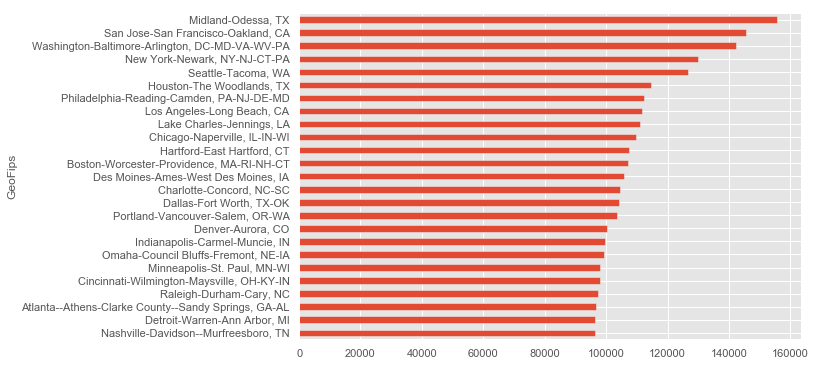

In [443]:
## load gdp separately - last year 2017
gdp_per_worker=pd.read_excel(os.path.join(drop,'Data/RHNA/gdp_per_worker.xlsx'),index_col=[1,2]).gdp_per_worker
gdp_per_worker=gdp_per_worker.unstack(1)[2017].dropna().sort_values(ascending=True).tail(25).plot(kind='barh')

In [522]:
## severe cost burden

#csasummary_burden_rent=hsgcost.loc(0)[:,['Rented']].estimate.groupby(level=[0,1]).apply(pct)
csasummary_burden_own=hsgcost.loc(0)[:,['Owned']].estimate.groupby(level=[0,1]).apply(pct).loc[:,:,'50 + pct'].reset_index(1,drop=True)
csasummary_burden_rent=hsgcost.loc(0)[:,['Rented']].estimate.groupby(level=[0,1]).apply(pct).loc[:,:,'50 + pct'].reset_index(1,drop=True)
#csasummary_burden_rent.sort_values()

In [445]:
## race

csasummary_race=persons.groupby(['CSA','rac_ethn_remi']).PWGTP.sum().groupby(level=0).apply(pct)
#csasummary_race

In [446]:
## hhincome

csasummary_hhinc=households.groupby(['CSA','inc_cat_coarse']).WGTP.sum().groupby(level=0).apply(pct)

In [790]:
csasummary_gini=households[households.HINCP.notnull()].groupby(['CSA']).apply(gini_df,val='HINCP',w='WGTP')#.unstack(1)#.plot(title='GINI Coefficient, by county')
csasummary_gini.head(3)

CSA
Albany-Schenectady, NY               0.44
Albuquerque-Santa Fe-Las Vegas, NM   0.49
Altoona-Huntingdon, PA               0.41
dtype: float64

In [791]:
## 95th percentile to 20th percentile ratios
csasummary_pct_95_20 = households.groupby('CSA').apply(group_median_SE_w_ratio,var='HINCP',percentile=[20,95],weight='WGTP').estimate
csasummary_pct_95_20.head(3)

CSA
Albany-Schenectady, NY                7.51
Albuquerque-Santa Fe-Las Vegas, NM   10.10
Altoona-Huntingdon, PA                6.51
Name: estimate, dtype: float64

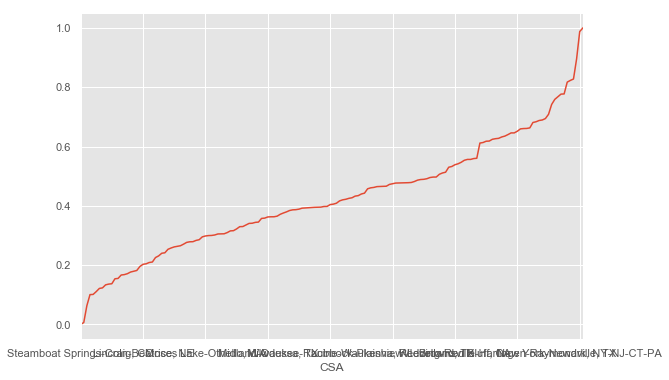

In [855]:
csasummary_pct_95_20_df=csasummary_pct_95_20.reset_index()
csasummary_pct_95_20_df['US']='us'
csasummary_pct_95_20_df['estim_scaled']=csasummary_pct_95_20_df.groupby('US').estimate.apply(rescale,new_range_low=0,new_range_hi=1)
csasummary_pct_95_20_scl=csasummary_pct_95_20_df.set_index('CSA').estim_scaled
csasummary_pct_95_20_scl.sort_values().plot()

In [447]:
## LFPR

csasummary_slf_15_65_mf=persons.loc[persons.AGEP.isin(range(15,65))].groupby(['CSA','in_labor_force']).PWGTP.sum().groupby(level=0).apply(pct).loc[:,'In Labor Force']
csasummary_slf_15_65_m=persons.loc[(persons.AGEP.isin(range(15,65)))&(persons.SEX==1)].groupby(['CSA','in_labor_force']).PWGTP.sum().groupby(level=0).apply(pct).loc[:,'In Labor Force']
csasummary_slf_15_65_f=persons.loc[(persons.AGEP.isin(range(15,65)))&(persons.SEX==2)].groupby(['CSA','in_labor_force']).PWGTP.sum().groupby(level=0).apply(pct).loc[:,'In Labor Force']

In [448]:
csasummary_slf_21_30_mf=persons.loc[persons.AGEP.isin(range(21,31))].groupby(['CSA','in_labor_force']).PWGTP.sum().groupby(level=0).apply(pct).loc[:,'In Labor Force']

In [449]:
## age groups

csasummary_youth=persons.groupby(['CSA','age_coarse']).PWGTP.sum().groupby(level=0).apply(pct).loc[:,'20-29']

csasummary_seniors=persons.groupby(['CSA','age_coarse']).PWGTP.sum().groupby(level=0).apply(pct).loc[:,'65p']

In [1020]:
## occupations

csasummary_occ_prof=persons.groupby(['CSA','occ_is_professional']).PWGTP.sum().groupby(level=0).apply(pct).unstack(1)[True]
csasummary_occ_svcs=persons.groupby(['CSA','occ_is_service']).PWGTP.sum().groupby(level=0).apply(pct).unstack(1)[True]

In [451]:
## built since 2005

csasummary_post2005=households.groupby(['CSA','yr_blt']).WGTP.sum().groupby(level=0).apply(pct).unstack(1)['2005 to 2018']

In [554]:
## vacant units

csasummary_vacant=households.groupby(['CSA','is_vacant']).WGTP.sum().groupby(level=0).apply(pct).loc[:,True]

In [555]:
## crowded households

csasummary_crowd=households.groupby(['CSA','is_crowded']).WGTP.sum().groupby(level=0).apply(pct).loc[:,True]

In [454]:
## povpip - Income-to-poverty ratio recode

csasummary_pov=persons[persons.POVPIP.notnull()].groupby(['CSA']).apply(group_median_SE_ALT,var='POVPIP',percentile=[50.],weight='PWGTP')
csasummary_pov=csasummary_pov['percentile_50.0'].estimate

In [455]:
## inc below poverty

csasummary_fpl=households.groupby(['CSA','hinc_belov_fpl']).WGTP.sum().groupby(level=0).apply(pct).unstack(1)[True]

In [456]:
## 2x inc below poverty

csasummary_fpl2x=households.groupby(['CSA','hinc_2x_belov_fpl']).WGTP.sum().groupby(level=0).apply(pct).unstack(1)[True]

In [457]:
## journey to work

csasummary_jtw=persons.groupby(['CSA','JWTR_l']).PWGTP.sum().groupby(level=0).apply(pct).unstack(1)
#csasummary_jtw

In [458]:
## move status from abroad

csasummary_fromabroad=persons.groupby(['CSA','MIG']).PWGTP.sum().groupby(level=0).apply(pct).unstack(1)[3]

In [969]:
## move status generally

csasummary_movestatus=persons.groupby(['CSA','movestatus']).PWGTP.sum().groupby(level=0).apply(pct).unstack(1)['Moved from outside region']

### Combine the various profile components - MAKE SURE order matches with keys list

In [1058]:
combodata=pd.concat([csasummary_gini,
                     csasummary_movestatus,
                     csasummary_fpl2x,#csasummary_pov,
                     csasummary_crowd,
                     csasummary_vacant,
                     csasummary_post2005,
                     csasummary_occ_prof,
                     csasummary_occ_svcs,
                     #csasummary_race,
                     #gdp_per_worker,
                     csasummary_hhinc.loc[:,'$0 to $49,999'],
                     csasummary_hhinc.loc[:,'$200,000 +'],
                     csasummary_slf_21_30_mf,
                     csasummary_slf_15_65_mf,
                     csasummary_seniors,
                     csasummary_youth,
                     csasummary_burden_rent
                    ],
         
         keys=['csasummary_gini',
               'csasummary_movestatus',
               'csasummary_fpl2x',#'csasummary_pov',
               'csasummary_crowd',
               'csasummary_vacant',
               'csasummary_post2005',
               'csasummary_occ_prof',
               'csasummary_occ_svcs',
               #'csasummary_race',
               #'gdp_per_worker',
               'csasummary_hhinc_low',
               'csasummary_hhinc_high',
               'csasummary_slf_21_30_mf',
               'csasummary_slf_15_65_mf',
               'csasummary_seniors',
               'csasummary_youth',
               'csasummary_burden_rent'],
                    names=['variable','csa'])

combodata=combodata.unstack('variable').dropna().loc[top_n_csas]#.drop(['gdp_per_worker'],axis=1)#,'csasummary_crowd','csasummary_vacant'],axis=1)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]), <a list of 15 Text xticklabel objects>)

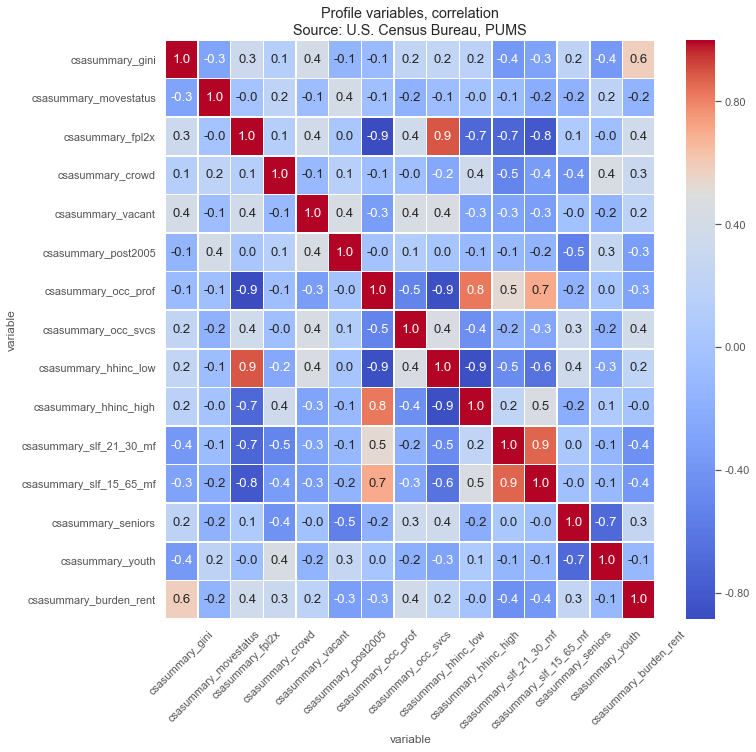

In [1059]:
fmt_abs = lambda x,pos: '{:,.2f}'.format(x)

fig, ax = plt.subplots()
fig.set_figwidth(11)
fig.set_figheight(11)        
ax=sns.heatmap(combodata.corr(),
             annot=True, fmt='.1f',annot_kws={"size": 13.1,'rotation':0},linewidths=.5,
              cbar_kws={'format': FuncFormatter(fmt_abs)},
               cmap=cm.coolwarm,norm=MidpointNormalize(midpoint=.5));
title('Profile variables, correlation\nSource: U.S. Census Bureau, PUMS')
plt.tight_layout()
plt.xticks(rotation=45)

In [1060]:
#CSA_target=combodata.loc[[u'San Jose-San Francisco-Oakland, CA']]
CSA_target=combodata.loc[[u'San Francisco Bay Area']]
CSA_target

variable,csasummary_gini,csasummary_movestatus,csasummary_fpl2x,csasummary_crowd,csasummary_vacant,csasummary_post2005,csasummary_occ_prof,csasummary_occ_svcs,csasummary_hhinc_low,csasummary_hhinc_high,csasummary_slf_21_30_mf,csasummary_slf_15_65_mf,csasummary_seniors,csasummary_youth,csasummary_burden_rent
CSA,,,,,,,,,,,,,,,
San Francisco Bay Area,0.48,0.06,0.16,0.07,0.02,0.09,0.33,0.33,0.24,0.23,0.83,0.77,0.15,0.14,0.23


In [1061]:
CSA_candidates=combodata.copy()
CSA_candidates_df=combodata.copy()
CSA_candidates_mat=combodata.copy().as_matrix()


/Users/aolsen/anaconda2/envs/geoenv/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


## Identify comparable regions
* We start with the universe of `top_n_csas` region, set at 50 regions
* We then identify the 7 regions (8 including the Bay Area) that are closest on the selected variable dimensions

In [1062]:
from scipy import spatial
RUNNERS_UP=50
rankmap={}
rankmap_ordinal={}

#tree = KDTree(CSA_candidates.fillna(0).as_matrix(), leaf_size=3)              

## actually the spatial version from scipy has a few more parameters 
tree = spatial.KDTree(CSA_candidates.fillna(0), leafsize=3) 
dist, ind = tree.query(CSA_target.fillna(0), 
                       k=RUNNERS_UP,p=2) # p parameter 1: manhattan dist; 2: euclidean

## nifty function to turn cardinal numbers into ordinal, from 
## https://codegolf.stackexchange.com/questions/4707/outputting-ordinal-numbers-1st-2nd-3rd#answer-4712

ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n/10%10!=1)*(n%10<4)*n%10::4])

for i,item in enumerate(zip(ind[0],dist[0])):
    rankmap[CSA_candidates.iloc[[ind[0,i]]].index.values[0]]=ordinal(i+1)
    rankmap_ordinal[CSA_candidates.iloc[[ind[0,i]]].index.values[0]]=int(i)
    print "{n} place: CSA {csa}, with an euclidean distance of {dist:0.3f}".format(
        n=ordinal(i+1),csa=CSA_candidates.iloc[[ind[0,i]]].index.values[0],dist=dist[0][i])

1st place: CSA San Francisco Bay Area, with an euclidean distance of 0.000
2nd place: CSA Washington-Baltimore-Arlington, DC-MD-VA-WV-PA, with an euclidean distance of 0.109
3rd place: CSA Seattle-Tacoma, WA, with an euclidean distance of 0.162
4th place: CSA Boston-Worcester-Providence, MA-RI-NH-CT, with an euclidean distance of 0.174
5th place: CSA Denver-Aurora, CO, with an euclidean distance of 0.191
6th place: CSA Minneapolis-St. Paul, MN-WI, with an euclidean distance of 0.200
7th place: CSA Hartford-East Hartford, CT, with an euclidean distance of 0.208
8th place: CSA New York-Newark, NY-NJ-CT-PA, with an euclidean distance of 0.210
9th place: CSA Portland-Vancouver-Salem, OR-WA, with an euclidean distance of 0.229
10th place: CSA Chicago-Naperville, IL-IN-WI, with an euclidean distance of 0.237
11th place: CSA Philadelphia-Reading-Camden, PA-NJ-DE-MD, with an euclidean distance of 0.253
12th place: CSA Sacramento-Roseville, CA, with an euclidean distance of 0.256
13th place: CS

Reassuringly, we see that San Francisco Bay Area is most similar to... itself!

We check an alternate approach, using k-means clusters - if we cluster the nation's top CSAs into 4 groups, which are the peers of SF Bay Area?

The overlap is considerable with the KDtree approach - serving as a bit of confirmation.

In [1063]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=1,n_init=500).fit(CSA_candidates_mat)

CSA_candidates_df['cluster']=kmeans.labels_
bayareaclusterid=CSA_candidates_df.loc['San Francisco Bay Area'].cluster
CSA_candidates_df[CSA_candidates_df.cluster==bayareaclusterid]


variable,csasummary_gini,csasummary_movestatus,csasummary_fpl2x,csasummary_crowd,csasummary_vacant,csasummary_post2005,csasummary_occ_prof,csasummary_occ_svcs,csasummary_hhinc_low,csasummary_hhinc_high,csasummary_slf_21_30_mf,csasummary_slf_15_65_mf,csasummary_seniors,csasummary_youth,csasummary_burden_rent,cluster
CSA,,,,,,,,,,,,,,,,
"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",0.46,0.04,0.16,0.02,0.03,0.12,0.32,0.34,0.27,0.16,0.85,0.78,0.14,0.13,0.23,0
"Boston-Worcester-Providence, MA-RI-NH-CT",0.48,0.03,0.20,0.02,0.02,0.08,0.26,0.37,0.33,0.13,0.83,0.77,0.16,0.14,0.24,0
San Francisco Bay Area,0.48,0.06,0.16,0.07,0.02,0.09,0.33,0.33,0.24,0.23,0.83,0.77,0.15,0.14,0.23,0
"Seattle-Tacoma, WA",0.45,0.06,0.16,0.03,0.02,0.17,0.29,0.35,0.29,0.12,0.84,0.76,0.15,0.14,0.22,0
"Minneapolis-St. Paul, MN-WI",0.45,0.03,0.19,0.03,0.02,0.11,0.26,0.37,0.32,0.10,0.88,0.81,0.14,0.14,0.23,0
"Denver-Aurora, CO",0.45,0.06,0.19,0.03,0.02,0.16,0.29,0.36,0.31,0.10,0.87,0.79,0.13,0.14,0.25,0


####  With this list of peer regions, we subset PUMS data to just person records in those regions
We use this subset to run summaries, averaged across the top 7 comparable regions.

In [1027]:
persons_comp=persons.loc[persons.CSA.isin(CSA_candidates.iloc[ind[0]].index[1:8])]
households_comp=households.loc[households.CSA.isin(CSA_candidates.iloc[ind[0]].index[1:8])]

In [1028]:
# CSA_candidates_for_r=CSA_candidates.iloc[ind[0]].append(CSA_candidates.loc[['Fresno-Madera-Hanford, CA']]).stack().reset_index(name='value')
# CSA_candidates_for_r.variable=CSA_candidates_for_r.variable.str.replace('csasummary_','')
# CSA_candidates_for_r.to_csv(os.path.join(drop,'Data/RHNA/pums_comparable_regions.csv'))

### Compile crowding, vacancy and cost burden data for different geographies

#### 1: NOT segmented by tenure

In [1029]:
pd.options.display.float_format = '{:,.2f}'.format
vacancy_geo_ten=pd.concat([
    ## region
    households_bayarea[households_bayarea.vac_status_gen.isin(['Owned','Rented'])].WGTP.sum()/\
    households_bayarea[households_bayarea.ten_univ.isin(['Owned','Rented'])].groupby(['RT','ten_univ']).WGTP.sum(),
    
    ## comparable
    households_comp[households_comp.vac_status_gen.isin(['Owned','Rented'])].WGTP.sum()/\
    households_comp[households_comp.ten_univ.isin(['Owned','Rented'])].groupby(['RT','ten_univ']).WGTP.sum(),
    
    # U.S.
    households[households.vac_status_gen.isin(['Owned','Rented'])].WGTP.sum()/\
    households[households.ten_univ.isin(['Owned','Rented'])].groupby(['RT','ten_univ']).WGTP.sum()],
           keys=['Bay Area','Comparable Regions','U.S.'],names=['Geography'])
vacancy_geo_ten

Geography           RT  ten_univ
Bay Area            H   Owned      0.04
                        Rented     0.05
Comparable Regions  H   Owned      0.04
                        Rented     0.06
U.S.                H   Owned      0.05
                        Rented     0.09
Name: WGTP, dtype: float64

In [1030]:
## vacancy percentage for comparable regions, by tenure, household income category
## for TENURE sheet

vacancy_geo_ten=pd.concat([
    ## region
    households_bayarea[households_bayarea.vac_status_gen.isin(['Owned','Rented'])].groupby(['vac_status_gen']).WGTP.sum()/\
    households_bayarea[households_bayarea.ten_univ.isin(['Owned','Rented'])].groupby(['ten_univ']).WGTP.sum(),
    
    ## comparable
    households_comp[households_comp.vac_status_gen.isin(['Owned','Rented'])].groupby(['vac_status_gen']).WGTP.sum()/\
    households_comp[households_comp.ten_univ.isin(['Owned','Rented'])].groupby(['ten_univ']).WGTP.sum(),
    
    # U.S.
    households[households.vac_status_gen.isin(['Owned','Rented'])].groupby(['vac_status_gen']).WGTP.sum()/\
    households[households.ten_univ.isin(['Owned','Rented'])].groupby(['ten_univ']).WGTP.sum()],
           keys=['Bay Area','Comparable Regions','U.S.'],names=['Geography'])


## add totals
vacancy_geo_ten_TOTAL=pd.concat([pd.concat([
    ## region
    households_bayarea[households_bayarea.vac_status_gen.isin(['Owned','Rented'])].WGTP.sum()/\
    households_bayarea[households_bayarea.ten_univ.isin(['Owned','Rented'])].groupby(['RT']).WGTP.sum(),
    
    ## comparable
    households_comp[households_comp.vac_status_gen.isin(['Owned','Rented'])].WGTP.sum()/\
    households_comp[households_comp.ten_univ.isin(['Owned','Rented'])].groupby(['RT']).WGTP.sum(),
    
    # U.S.
    households[households.vac_status_gen.isin(['Owned','Rented'])].WGTP.sum()/\
    households[households.ten_univ.isin(['Owned','Rented'])].groupby(['RT']).WGTP.sum()],
           keys=['Bay Area','Comparable Regions','U.S.'],names=['Geography'])],
                                keys=['Total'],names=['vac_status_gen']).reset_index('RT',drop=True).reorder_levels(vacancy_geo_ten.index.names)

vacancy_geo_ten=vacancy_geo_ten.append(vacancy_geo_ten_TOTAL).sort_index()

vacancy_geo_ten.unstack()

vac_status_gen,Owned,Rented,Total
Geography,,,
Bay Area,0.01,0.04,0.02
Comparable Regions,0.01,0.04,0.02
U.S.,0.02,0.06,0.03


In [1031]:
## crowding percentage for comparable regions

comparable_burden=pd.concat([households_bayarea.groupby(['is_cost_burdened']).WGTP.sum()/households_bayarea.WGTP.sum(),
            (households_comp.groupby(['is_cost_burdened']).WGTP.sum()/households_comp.WGTP.sum()),
           (households.groupby(['is_cost_burdened']).WGTP.sum()/households.WGTP.sum())],
           keys=['Bay Area','Comparable Regions','U.S.'],names=['Geography']).unstack(1)
comparable_burden

is_cost_burdened,False,True
Geography,,
Bay Area,0.67,0.33
Comparable Regions,0.68,0.32
U.S.,0.73,0.27


In [1032]:
## cost burden percentage for comparable regions

comparable_crowding=pd.concat([households_bayarea.groupby(['is_crowded']).WGTP.sum()/households_bayarea.WGTP.sum(),
            (households_comp.groupby(['is_crowded']).WGTP.sum()/households_comp.WGTP.sum()),
           (households.groupby(['is_crowded']).WGTP.sum()/households.WGTP.sum())],
           keys=['Bay Area','Comparable Regions','U.S.'],names=['Geography']).unstack(1)
comparable_crowding

is_crowded,False,True
Geography,,
Bay Area,0.93,0.07
Comparable Regions,0.97,0.03
U.S.,0.97,0.03


#### 2: Segmented  by tenure

In [1033]:
## crowding percentage for comparable regions

comparable_crowding_ten=pd.concat([households_bayarea.groupby(['TEN_l','is_crowded']).WGTP.sum()/households_bayarea.groupby('TEN_l').WGTP.sum(),
            (households_comp.groupby(['TEN_l','is_crowded']).WGTP.sum()/households_comp.groupby('TEN_l').WGTP.sum()),
           (households.groupby(['TEN_l','is_crowded']).WGTP.sum()/households.groupby('TEN_l').WGTP.sum())],
           keys=['Bay Area','Comparable Regions','U.S.'],names=['Geography']).unstack(1)
comparable_crowding_ten=comparable_crowding_ten.loc(0)[:,True][['Owned','Rented']]
comparable_crowding_ten

,TEN_l,Owned,Rented
Geography,is_crowded,,
Bay Area,True,0.03,0.13
Comparable Regions,True,0.02,0.07
U.S.,True,0.02,0.06


In [1034]:
## cost burden percentage for comparable regions

comparable_burdened_ten=pd.concat([households_bayarea.groupby(['TEN_l','is_cost_burdened']).WGTP.sum()/households_bayarea.groupby('TEN_l').WGTP.sum(),
            (households_comp.groupby(['TEN_l','is_cost_burdened']).WGTP.sum()/households_comp.groupby('TEN_l').WGTP.sum()),
           (households.groupby(['TEN_l','is_cost_burdened']).WGTP.sum()/households.groupby('TEN_l').WGTP.sum())],
           keys=['Bay Area','Comparable Regions','U.S.'],names=['Geography']).unstack(1)
comparable_burdened_ten=comparable_burdened_ten.loc(0)[:,True][['Owned','Rented']]
comparable_burdened_ten

,TEN_l,Owned,Rented
Geography,is_cost_burdened,,
Bay Area,True,0.29,0.46
Comparable Regions,True,0.27,0.50
U.S.,True,0.22,0.49


In [1035]:
## WITH TOTALS - cost burden percentage for comparable regions, by tenure, household income category

compraable_crowd_ten=pd.concat([
    ## region
    households_bayarea.groupby(['RT','TEN_l','is_crowded']).WGTP.sum()/households_bayarea.groupby(['RT','TEN_l']).WGTP.sum(),
    
    ## comparable
    households_comp.groupby(['RT','TEN_l','is_crowded']).WGTP.sum()/households_comp.groupby(['RT','TEN_l']).WGTP.sum(),
    
    # U.S.
    (households.groupby(['RT','TEN_l','is_crowded']).WGTP.sum()/households.groupby(['RT','TEN_l']).WGTP.sum())],
           keys=['Bay Area','Comparable Regions','U.S.'],names=['Geography'])


## add totals
compraable_crowd_ten_TOTAL=pd.concat([pd.concat([## region
    households_bayarea.groupby(['RT','is_crowded']).WGTP.sum()/households_bayarea[households_bayarea.TEN_l!='VAC/GQ'].groupby(['RT']).WGTP.sum(),

    ## comparable
    households_comp.groupby(['RT','is_crowded']).WGTP.sum()/households_comp[households_comp.TEN_l!='VAC/GQ'].groupby(['RT']).WGTP.sum(),

    # U.S.
    (households.groupby(['RT','is_crowded']).WGTP.sum()/households[households.TEN_l!='VAC/GQ'].groupby(['RT']).WGTP.sum())],
    keys=['Bay Area','Comparable Regions','U.S.'],names=['Geography'])],keys=['Total'],names=['TEN_l'])
compraable_crowd_ten_TOTAL=compraable_crowd_ten_TOTAL.reorder_levels(compraable_crowd_ten.index.names)
compraable_crowd_ten=compraable_crowd_ten.append(compraable_crowd_ten_TOTAL).sort_index().loc[:,:,['Owned','Rented','Total'],True].reset_index(['RT','is_crowded'],drop=True)


#### 3: Segmented  by tenure, 80% AMI

In [1036]:
## WITH TOTALS cost burden percentage for comparable regions, by tenure, household income category

comparable_burdened_ten_AMI=pd.concat([
    ## region
    households_bayarea.groupby(['hhinc_above_80pct_AMI_HUD','TEN_l','is_cost_burdened']).WGTP.sum()/households_bayarea.groupby(['hhinc_above_80pct_AMI_HUD','TEN_l']).WGTP.sum(),
    
    ## comparable
    households_comp.groupby(['hhinc_above_80pct_AMI_HUD','TEN_l','is_cost_burdened']).WGTP.sum()/households_comp.groupby(['hhinc_above_80pct_AMI_HUD','TEN_l']).WGTP.sum(),
    
    # U.S.
    (households.groupby(['hhinc_above_80pct_AMI_HUD','TEN_l','is_cost_burdened']).WGTP.sum()/households.groupby(['hhinc_above_80pct_AMI_HUD','TEN_l']).WGTP.sum())],
           keys=['Bay Area','Comparable Regions','U.S.'],names=['Geography'])


## add totals
comparable_burdened_ten_AMI_TOTAL=pd.concat([pd.concat([## region
    households_bayarea.groupby(['hhinc_above_80pct_AMI_HUD','is_cost_burdened']).WGTP.sum()/households_bayarea[households_bayarea.TEN_l!='VAC/GQ'].groupby(['hhinc_above_80pct_AMI_HUD']).WGTP.sum(),

    ## comparable
    households_comp.groupby(['hhinc_above_80pct_AMI_HUD','is_cost_burdened']).WGTP.sum()/households_comp[households_comp.TEN_l!='VAC/GQ'].groupby(['hhinc_above_80pct_AMI_HUD']).WGTP.sum(),

    # U.S.
    (households.groupby(['hhinc_above_80pct_AMI_HUD','is_cost_burdened']).WGTP.sum()/households[households.TEN_l!='VAC/GQ'].groupby(['hhinc_above_80pct_AMI_HUD']).WGTP.sum())],
    keys=['Bay Area','Comparable Regions','U.S.'],names=['Geography'])],keys=['Total'],names=['TEN_l'])
comparable_burdened_ten_AMI_TOTAL=comparable_burdened_ten_AMI_TOTAL.reorder_levels(comparable_burdened_ten_AMI.index.names)
comparable_burdened_ten_AMI=comparable_burdened_ten_AMI.append(comparable_burdened_ten_AMI_TOTAL).sort_index()

In [88]:
comparable_burdened_ten_AMI

NameError: name 'comparable_burdened_ten_AMI' is not defined

In [1037]:
## for RHNA sheet, reference table

unstack_levels=['TEN_l','Geography']
rhna_ref_table=comparable_burdened_ten_AMI.loc[:,:,['Owned','Rented','Total'],True].unstack(unstack_levels).reset_index(1,drop=True)\
.append(pd.concat([compraable_crowd_ten],keys=['crowded'],names=['variable','Geography','TEN_l']).unstack(unstack_levels))\
.append(pd.concat([vacancy_geo_ten],keys=['vacancy'],names=['variable','Geography','TEN_l']).unstack(unstack_levels)).sort_index(axis=1)
rhna_ref_table.sort_index(ascending=False).to_clipboard()

In [1051]:
## for r - write summary stressors
rhna_ref_table_r=rhna_ref_table.stack(level=[0,1]).reset_index(name='value').rename(columns={'level_0':'Measure'})
rhna_ref_table_r.Measure=rhna_ref_table_r.Measure.map({'hhinc_gt_80pct':'Burdened (HH Income >=80% AMI)',
                              'hhinc_lt_80pct':'Burdened (HH Income <80% AMI)', 'crowded':'Crowded', 'vacancy':'Vacant'})
rhna_ref_table_r.Geography=rhna_ref_table_r.Geography.map({'Bay Area':'SFBA','Comparable Regions':'Comp.','U.S.':'U.S.'})
rhna_ref_table_r.to_csv(os.path.join(drop,'Data/RHNA/comparable_burden_v2.csv'))

In [1039]:
pd.concat([pd.concat([comparable_burden.stack(),
                      comparable_crowding.stack()],
                     keys=['Cost Burdened Households','Crowded Households'],
                     names=['Measure','Geography','impacted']).loc[:,:,True]],keys=['Total'],names=['TEN_l']).append(pd.concat([comparable_crowding_ten,comparable_burdened_ten],keys=['Crowded Households','Cost Burdened Households'],
         names=['Measure']).stack().unstack(0).reset_index(1,drop=True).stack().reset_index(name='value').set_index(['TEN_l','Measure','Geography']).value).sort_index().reset_index(name='value')#.to_csv(os.path.join(drop,'Data/RHNA/comparable_burden.csv'))

,TEN_l,Measure,Geography,value
0,Owned,Cost Burdened Households,Bay Area,0.29
1,Owned,Cost Burdened Households,Comparable Regions,0.27
2,Owned,Cost Burdened Households,U.S.,0.22
3,Owned,Crowded Households,Bay Area,0.03
4,Owned,Crowded Households,Comparable Regions,0.02
5,Owned,Crowded Households,U.S.,0.02
6,Rented,Cost Burdened Households,Bay Area,0.46
7,Rented,Cost Burdened Households,Comparable Regions,0.50
8,Rented,Cost Burdened Households,U.S.,0.49
9,Rented,Crowded Households,Bay Area,0.13


In [1040]:
# ## cost burden percentage for comparable regions, by tenure, household income

# comparable_burdened_ten_AMI_abs=pd.concat([
#     households_bayarea.groupby(['hhinc_above_80pct_AMI_HUD','TEN_l','is_cost_burdened']).WGTP.sum(),
#     households_comp.groupby(['hhinc_above_80pct_AMI_HUD','TEN_l','is_cost_burdened']).WGTP.sum(),
#     households.groupby(['hhinc_above_80pct_AMI_HUD','TEN_l','is_cost_burdened']).WGTP.sum()],
#            keys=['Bay Area','Comparable Regions','U.S.'],names=['Geography'])
# comparable_burdened_ten_AMI_abs

In [1041]:
CSA_candidates_for_r=pd.concat([CSA_candidates.iloc[ind[0][1:8]],
                                CSA_candidates.loc[['San Francisco Bay Area']],
                                CSA_candidates.iloc[[-1]]],keys=['Comparables','Bay Area','Example\nOutlier'],names=['grouping']).stack().reset_index(name='value')

CSA_candidates_for_r.variable=CSA_candidates_for_r.variable.str.replace('csasummary_','')
CSA_candidates_for_r.to_csv(os.path.join(drop,'Data/RHNA/pums_comparable_regions.csv'))

In [1042]:
pd.options.display.float_format = '{:,.2f}'.format
hcdpath=os.path.join(box,'RHNA/RHND/consultation/To HCD')
CSA_candidates.iloc[ind[0][0:8]].rename(columns=lambda x: x.replace('csasummary_','')).T.to_excel(os.path.join(hcdpath,'comparable_component_stats_v2.xlsx'))